# Primer to Support Vector Machines

### By Dr. Jonne Pohjankukka

 This tutorial is an ongoing self-made project based on my exercise work on mathematical optimization in 2015. The project is yet unfinished and not in a fully readable state. The upcoming versions will include: 

 updates in the text, fixing of typos, references, added code etc. 

1. [Machine learning](#1.)<br>
2. [Linear vs. nonlinear models](#2.)<br>
3. [Support vector machines](#3.)<br>
    3.1 [How to find the maximum margin model?](#3.1)<br>
    3.2 [Is maximum margin model really better?](#3.2)<br>
    3.3 [What if data is not linearly separable?](#3.3)<br>
    3.4 [Kernel methods](#3.4)<br>
4. [Solving the optimal SVM](#4.)<br>
    4.1 [Quadratic programming](#4.1)<br>
    4.2 [Lagrangian dual](#4.2)<br>
    4.3 [The dual of hard margin SVM](#4.3)<br>
    4.4 [Example: solving the SVM classifier via the Lagrangian dual form](#4.4)<br>
    4.5 [The dual in the $\mathcal{Z}$-space](#4.5)<br>
5. [Simple algorithm for solving the SVM model](#5.)<br>
    5.1 [Active set methods](#5.1)<br>
    5.2 [Gradient projection](#5.2)<br>
    5.3 [Pseudocode for simple SVM solver](#5.3)<br>
6. [Appendix: code listing](#Appendix)<br>

#### Preface: to whom is this tutorial for? 
I think it was back in 2014 or 2015 when I first came across with support vector machines and I remember being frustrated for the difficulty of finding good practical tutorials on the subject. I could find many tutorials online describing the theory and general ideas, but everytime after reading them I had one question: okay, now what? What do I type in my IDE? I could understand the idea, but when I needed to do some programming I found out I actually did not understand it that well. So what I did next was to search again online for some advices, and I found out these guides repeating themselves: "use a package", "download and apply a package". I understand that this is a perfectly valid solution if your goal is simply to apply support vector machines. In my case, I wanted to understand **every step going on under the hood**. I wanted to understand how one constructs a support vector machine model, how does one train it et cetera **without using any packages at all** (excluding trivial packages of course such as NumPy). How does one implement the model, the mathematical optimization, kernel tricks, everything by yourself? 

This tutorial is an attempt to provide readers a primer into the subject who have similar problems and frustrations that I had when first running into the subject. I will provide the reader with the general idea of support vector machines, its basic theretical background, practical pen-and-paper examples, pseudocode and Python codes which do not apply any packages related to machines learning or mathematical optimization. I will assume the reader has some understanding on probability, linear algebra and mathematical optimization. Enjoy the ride =) 



<a id='1.'></a>
#### 1. Machine learning
What is machine learning (ML)? ML is a subfield of computer science focused on the research and desing of models, which aim to discover and learn patterns from data. Applications of ML could be for example the prediction of stock price values, classification of soil bearing capacity, or forecasting the effects of drinking milk to the acidity levels in human stomach. ML combines techniques from many fields of science, such as probability theory, statistics, physics, mathematical optimization and neuroscience. 

One of the most important (or maybe better say **the most important**) issues in ML is the concept of generalizability, which measures how well a ML model performs in making predictions in new situations (that is, with new data). A model probably fails to generalize well, if it is "fitted" too much to the data (this claim is also backed up theoretically). The notion of "fitting a model to data", usually means that we minimize some error function, which describes the goodness-of-fit of our model to the data. The lower the error, the better the fit. In fields such as mathmetical optimization or calculus of variation, the goal is many times to find the absolute minimum of this error (say, the optimum trajectory of a particle). It has however been shown, both from a theoretical and practical perspective, that if you train a model too much _overfitting_ will occur. 

Overfitting means that the model has learned not only the intrinsic phenomena in the data, but also an additional non-existing relationship called _noise_, which can not be learned by definition. Noise is present in all data you ever measure and can be caused e.g. by measurement errors, weather or malfunctioning sensors. Thus by overfitting a model, we have learned an incorrent relationship from the data, and are more likely to generalize worse. A common way to tackel overfitting is to apply a method known as _regularization_, which basically means restricting the learning process by preventing it from learning too complicated functions. There are many ways to tackle overfitting such as using penalty term or early-stopping methods, but we will not go deeper into this subject in this tutorial. Readers interested with overfitting can find more information from standard ML literature. 

<a id='2.'></a>
#### 2. Linear vs. nonlinear models
All methods of ML can be divided into two groups: linear or nonlinear. Linear models are simple and effective methods in many applications describing real world phenomena, but sometimes their expressive power is not enough to learn more complicated relationships in the data. In cases like this, nonlinear methods are usually applied due to their higher expressive power. However, due to its simplicity a linear model is less likely to overfit than nonlinear model. Also in general, nonlinear models require more data than linear models to achieve succesful generalization. There is therefore a trade-off between the expressive power of a model and its likelihood of overfitting to the data. Because of the higher expressive power, nonlinear models are more easily fitted to the noise in the data. With this in mind, it begs now the question: does there exist a model which contains both the resistance towards noise (as in linear models) and high expressive power (as in nonlinear models). A clever method called _support vector machines_ (SVM) was proposed for achieving this by Vladimir Vapnik and Alexey Chervonenkis in 1963, which we will discuss next. In what follows, we will go through the motivation, theory, examples and a self-made implementation (in pseudo- and Python code) of the SVM method.   

<a id='3.'></a>
#### 3. Support vector machines
We will begin with a simple geometric illustration, which best explains the intuition behind SVM. In figure 1 is presented data from two different classes denoted by blue crosses and red circles. The lines depict three competing decision lines which we use to determine the classification regions. The data is _linearly separable_ which means that the data can be divided into two distinct subspaces by the line (or a hyperplane in higher dimensions). Which of these three lines would the best choice and why? Or would you say they are all equally good? After all, all the lines perfectly classify the data. I'm betting however, that you would probably select the line in the rightmost image. Why would we choose this line? What is the intuition behind our choice? Remember that all data we ever measure contains noise. It would be good therefore to select such a decision line which would be most robust against this noise. You can think of the effect of noise in the four data points by shifting them randomly into arbitrary directions a tiny bit. We would want the decision line to allow as much of this random shifting (due to noise) as possible and still achieve correct classification. You would agree that decision line in the rightmost image allows the largest amount of random shifting in the points in the image, right? 

In [1]:
# Make Figure 1 plot
drawClassifierLines(showRadius=False)

NameError: name 'drawClassifierLines' is not defined

<center>Figure 1: Geometric intuition behind the SVM.</center>

As we discussed, we would like to select a decision line which allows as much as possible this random shifting in the data (i.e. noise) without affecting the classification. We can picture this random shifting caused by noise in terms of circles or spheres with radius $r$ around the data points (see figure 2). Notice that in the rightmost image the circles have the largest radius, and so we can think that the data points are allowed to move within this circle (i.e. we have uncertainty) and still we get correct classification. What we would like to do, is to select a linear classifier which maximizes the radius of these spheres. In this way, we have maximized the model's robustness against noise in the data. Notice that in the rightmost image, the distance from the line to the closest data points is maximized. The data points at which the spheres first touch the decision line are called _support vectors_, from which the name of the SVM comes from. The support vectors play a special role in the SVM since they are solely responsible in determining the classifier line. If we would for example remove the rightmost data point from the below images, it would not affect the choice of the classifier line, only the support vectors have impact on this. Lastly, since in SVM the point is to maximize the distance of the line to the support vectors (called the _margin_), SVMs are also called _maximum margin models_.       

In [ ]:
# Make Figure 2 plot
drawClassifierLines(showRadius=True)

<center>Figure 2: Uncertainties around the data points in figure 1 illustrated.</center>

<a id='3.1'></a>
#### 3.1 How to find the maximum margin model? 
Lets now proceed to formalize the concepts of the SVM and find out how can we solve the maximum margin hyperplane. Denote by $\textbf{x}\in\mathcal{X}\subset\mathbb{R}^d$ an input vector, $\textbf{w}\in\mathbb{R}^d$ as hyperplane weight values, $y\in\{-1, 1\}$ as label value and $b\in\mathbb{R}$ as a constant intercept term. A hyperplane $h$ defined by vector $\textbf{w}$ and constant $b$ separates the data points $(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n)$ if and only if: 

$$y_i(\textbf{w}^T\textbf{x}_i+b) > 0\;\;\;(i = 1, 2, ..., n),\;\;\;\;\;\;\;\;\;\;\;\;(1)$$

where $h(\textbf{x}) = \textbf{w}^T\textbf{x}+b$ is called the _signal_ of input $\textbf{x}$. That is, for data points having $y=-1$ we want the hyperplane to have a negative signal $h(\textbf{x}) <0$ and for data points with $y=1$ we want $h(\textbf{x}) >0$ correspondingly. Notice next that the equations in $(1)$ are always satisfied also for any $h(\textbf{x})/\rho$, where $\rho > 0$. Define next (for reasons later coming clear):

$$\rho := \underset{i = 1, 2, ..., n}{\text{min}} y_i(\textbf{w}^T\textbf{x}_i+b),$$

and redefine the separating hyperplane as $h(\textbf{x})/\rho$. For this redefined hyperplane we have: 

$$\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\frac{h(\textbf{x})}{\rho}\right)=\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\frac{\textbf{w}^T\textbf{x}_i}{\rho}+\frac{b}{\rho}\right)=\frac{1}{\rho}\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^T\textbf{x}_i+b\right)=\frac{\rho}{\rho}=1,$$

that is, the hyperplane separates all the data points if and only if: 

$$\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^T\textbf{x}_i+b\right)=1.\;\;\;\;\;\;\;\;\;\;\;\;(2)$$

So we have now learned that a hyperplane $h$ separates the data points only if the condition in $(2)$ is met. This condition is not yet though sufficient enough to define the problem of finding a maximum margin hyperplane. Recall that one of the defining factors of the SVM was also the fact that the margin (distance to the closest, a.k.a support vectors) needs to maximized. In other words, we want to maximize the distance between the hyperplane $h$ and the vector $\textbf{x}$ closest to it. 

To start, lets first figure out how one generally calculates the distance between a hyperplane and a vector point. To solve this distance we need to calculate the perpendicular distance between $h$ and $\textbf{x}$. Let $\textbf{u}$ be a unit vector perpendicular to $h$ and $\textbf{x}'$ some point on $h$, i.e. $h(\textbf{x}') = \textbf{w}^T\textbf{x}' + b = 0$. Then, from basic linear algebra (make e.g. a Google search) we know that the distance between $h$ and point $\textbf{x}$ is the projection $d(h, \textbf{x}) = |\textbf{u}^T(\textbf{x}-\textbf{x}')|$. Note that $\textbf{w}$ is perpendicular to the plane $h$, since for two points $\textbf{x}', \textbf{x}''$ on the plane $h$ we have:

$$\textbf{w}^T(\textbf{x}''-\textbf{x}') = \textbf{w}^T\textbf{x}''-\textbf{w}^T\textbf{x}'=-b+b = 0,$$

that is $\textbf{w}$ is perpendicular to any vector $\textbf{x}''-\textbf{x}'$ on $h$. We can now set $\textbf{u} = \textbf{w}/||\textbf{w}||$, where $||\textbf{w}||$ is the magnitude of vector $\textbf{w}$. Hence, we get the distance from an arbitrary point $\textbf{x}$ to plane $h$ as: 

$$d(h, \textbf{x}) = \frac{\left\lvert\textbf{w}^T(\textbf{x}-\textbf{x}')\right\rvert}{||\textbf{w}||}= \frac{\left\lvert\textbf{w}^T\textbf{x}-\textbf{w}^T\textbf{x}'\right\rvert}{||\textbf{w}||} = \frac{\left\lvert\textbf{w}^T\textbf{x}+b\right\rvert}{||\textbf{w}||}.$$

Furthermore, since for a binary SVM classifier we have $y_i\in \{-1, 1\} \forall i$, we get: 

$$\left\lvert\textbf{w}^T\textbf{x}_i+b\right\rvert = y_i(\textbf{w}^T\textbf{x}_i+b)\;\forall i,$$

and because of $(2)$ we have that:

$$\underset{i = 1, 2, ..., n}{\text{min}} d(h, \textbf{x}_i) = \underset{i = 1, 2, ..., n}{\text{min}} \frac{y_i(\textbf{w}^T\textbf{x}_i+b)}{||\textbf{w}||}= \frac{1}{||\textbf{w}||}\underset{i = 1, 2, ..., n}{\text{min}} y_i(\textbf{w}^T\textbf{x}_i+b) = \frac{1}{||\textbf{w}||}.\;\;\;\;\;\;\;\;\;\;\;\;(3)$$

The nice and simple form of equation $(3)$ is the reason why we redefined the hyperplane $h$ earlier by scaling it with the constant $\rho$, giving us thus a nice numerator of 1. We have now found all the ingredients we need to define the problem of solving the maximum margin model: A SVM model (binary classification) is such a hyperplane, which maximizes the value of $1/||\textbf{w}||$ (margin) and satisfies the condition in equation $(2)$. This can expressed in the following optimization problem: 

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & \underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^T\textbf{x}_i+b\right)=1.
\;\;\;\;\;\;\;\;\;\;\;\;(4)
\end{alignat}

From the perspective of mathematical optimization, it is easier to solve the problem:

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & y_i\left(\textbf{w}^T\textbf{x}_i+b\right)\geq 1,\;\;\;(i=1,2, ..., n)
\;\;\;\;\;\;\;\;\;\;\;\;(5)
\end{alignat}

which is equivalent to problem $(4)$ at the optimal solution, given that the data set contains samples with negative and positive labels. To show that equations $(4)$ and $(5)$ are equivalent at the optimum, suppose the solution $(\textbf{w}^*, b^*)$ of equation $(5)$ has: 

$$\rho^* = \underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^{*T}\textbf{x}_i+b^*\right) > 1,$$

which means that $(\textbf{w}^*, b^*)$ is not a solution to equation $(4)$. Consider now a hyperplane $(\textbf{w}, b) = \frac{1}{\rho^*}(\textbf{w}^*, b^*)$ which satisfies the constraints in equation $(5)$. But now we have that $||\textbf{w}|| = \frac{1}{\rho^*}||\textbf{w}^*|| < ||\textbf{w}^*||$, which means that $\textbf{w}^*$ can not be optimal for equation $(5)$ unless $\textbf{w}^*=\textbf{0}$. This however is not possible, because the hyperplane $(\textbf{0}, b)$ can not correctly classify the negative and positive data samples $\blacksquare$. So, once we have solved the optimal solution $(\textbf{w}^*, b^*)$ to equation $(5)$, we get the maximum margin classifier model (a.k.a SVM) as: 

$$g(\textbf{x})=\text{sign}\left(\textbf{w}^{*T}\textbf{x}+b^*\right)\in\{-1, 1\}.\;\;\;\;\;\;\;\;\;\;\;\;(6)$$

In the upcoming sections, we will see how to solve the optimization problem of equation $(5)$. First however, we will have a short discussion on why the maximum margin model is better than a non-maximum margin model in terms of generalizability. 

<a id='3.2'></a>
#### 3.2 Is maximum margin model really better?
In earlier sections, we had the intuition that a linear classifier with a larger margin would probably perform better than one with a smaller margin. In fact, our intuition is justified also mathematically by a special number called the _Vapnik-Chervonenkis-dimension_ $d_{\text{VC}}\in \mathbb{N}_{>0}$ (VC-dimension), which quantifies a probabilistic bound for the classification error of the SVM model. Generally speaking, a model with a smaller VC-dimension is more likely to achieve succesful generalization than one with a higher VC-dimension. And it is indeed the case (see the works of e.g. V. Vapnik), that the VC-dimension of a SVM model is smaller than the VC-dimension of an unrestricted linear classifier (unrestricted by the margin that is). This fact is a result from an inequality called the _VC-inequality_ (related closely to the Hoeffding inequality), which states that: 

$$P\left[\underset{h\in\mathcal{H}}{\text{sup}}\left\lvert E_{\text{in}}(h)-E_{\text{out}}(h)\right\rvert > \varepsilon \right] \leq 4m_{\mathcal{H}}(2n)\exp\left(-\frac{1}{8}\varepsilon^2 n\right),\;\;\;\;\;\;\;\;\;\;\;\;(7)$$

where $\mathcal{H}$ is the hypothesis set, that is, a set of functions from which we are searching for the model $h$, $\varepsilon >0$ is an error bound and $n\in\mathbb{N}_{>0}$ is the number of data points. The functions $E_{\text{in}}(h), E_{\text{out}}(h): \mathcal{H}\to \mathbb{R}$ denote the training and generalization errors of hypothesis $h$. That is, $E_{\text{in}}(h)$ describes how well we were able to fit model $h$ to the observed data $\mathcal{D}=\{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n)\}$, and $E_{\text{out}}(h)$ describes how well the model $h$ performs with new yet unseen data. Our goal is to have $E_{\text{in}}(h)\approx E_{\text{out}}(h)$, because in this case the we can trust that our model's performance estimated with the data set $\mathcal{D}$ reflects its performance in a general situation. 

The function $m_{\mathcal{H}}(2n):\mathbb{N}_{>0}\to \mathbb{N}$ maps $2n$ to a number, which describes the maximum number of dichotomies that can be generated by the hypothesis set $\mathcal{H}$ on any $2n$ data points. In other words, it gives a quantifying number on how many ways the hypothesis set $\mathcal{H}$ can split $2n$ data points into two categories. If $m_{\mathcal{H}}(c) = 2^{c}$ for $c$ data points, then we say that the hypothesis set $\mathcal{H}$ is able _shatter_ the $c$ data points, that is find all possible dichotomies (classifications) for the data. To put the relationship between $d_{\text{VC}}$ and $m_{\mathcal{H}}(c)$ explicit, the VC-dimension is defined as $d_{\text{VC}}\equiv \max\{c\in\mathbb{N}\,|\,m_\mathcal{H}(c)=2^c\}$. In other words, VC-dimension is the maximum number of data points the hypothesis set $\mathcal{H}$ is able to shatter. The next question now is, what has the VC-dimension got to do with the VC-inequality? It is known, that if a hypothesis set $\mathcal{H}$ has a finite $d_{\text{VC}}$, then it holds that: 

$$m_{\mathcal{H}}(2n) \leq \sum_{i=0}^{d_{\text{VC}}} {{2n}\choose i},$$

and therefore a hypothesis set with a smaller VC-dimension has a smaller multiplying factor in the right side of equation $(7)$ resulting in a smaller probability bound. This is also somewhat intuitive if you think about. If you are using a hypothesis set with unrestricted (by the margin) classifier models, then you would probably be able to find more dichotomies for the data set $\mathcal{D}$, than with the hypothesis set consisting from models with the restriction to maximize the margin. With a large number of equally good hypotheses to choose from, you would have smaller chances (a higher probability bound in the VC-inequality) to pick the right one unless you are very lucky.    

<a id='3.3'></a>
#### 3.3 What if data is not linearly separable?
So far, we have been talking about cases where the data set can be separated by a linear model. In many practical situations however the data set can not be separated by a linear model. In Figure 3 I have illustrated two examples of data sets which can not be separated by a linear model.

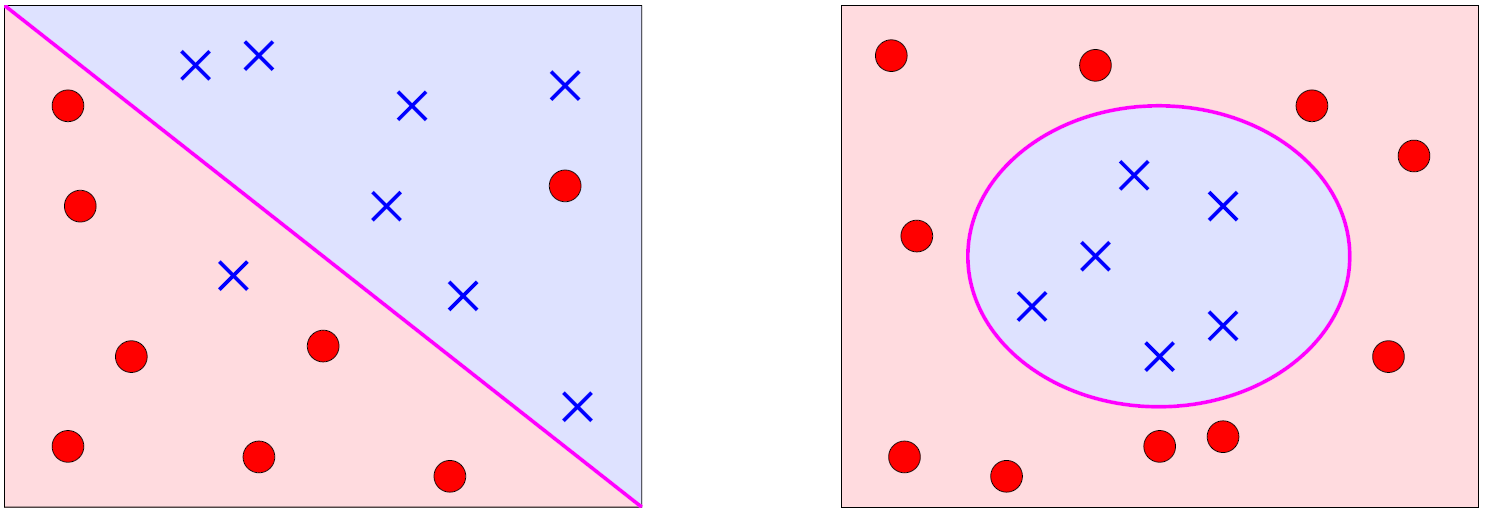
<center>Figure 3: Data which is not linearly separable.</center>

So how should we proceed from this? Well, fortunately we two options two consider. Firstly, we can loosen up the condition on the SVM which requires all the data points to be classified correctly. We do this by allowing few misclassifications for the model to occur. An SVM with a looser condition like this is called the _soft margin SVM_, which does not force a perfect classification and allows some mistakes to occur. On the left side of figure 3, we see an example of a soft margin SVM model. Our second option to the separability problem, is to first apply a nonlinear transformation to the data making it linearly separable, and then fit a hard margin linear SVM into this transformed data. In the right side of figure 3 is an example of this second approach. Note that the nonlinear model you seen here is a representation of the linear model of the transformed space in the original data space. The nonlinear transformation is achieved by a function $\Phi:\mathcal{X} \to \mathcal{Z}\subset \mathbb{R}^q$, which transforms the input vectors into $\textbf{z}_i = \Phi(\textbf{x}_i)$. After the transformation, the optimization problem in equation $(5)$ becomes: 

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & y_i\left(\textbf{w}^T\textbf{z}_i+b\right)\geq 1,\;\;\;(i=1,2, ..., n),
\;\;\;\;\;\;\;\;\;\;\;\;(8)
\end{alignat}

and similarly to equation $(6)$ we get the nonlinear hard margin SVM model as:

$$g(\textbf{x})=\text{sign}\left(\textbf{w}^{*T}\Phi(\textbf{x})+b^*\right)\in\{-1, 1\}.\;\;\;\;\;\;\;\;\;\;\;\;(9)$$

What happens to the generalization capability if we use nonlinear transformation for the data? Does it get worse? In general, the price we pay for using nonlinear models with higher expressive power is that we have a larger risk to overfit the data and that the probability of successful generalization decreases. Fortunately, a neat mathematical theorem exists (see e.g. Mostafa et al. for proofs) which helps us tackle the generalization problem of SVMs using nonlinear transformation. The theorem states that: 

**Theorem:** the VC-dimension of maximum margin classifier SVM with bounded input data $||\textbf{x}||\leq R$ and margin $r\in \mathbb{R}^{+}$ follows the inequality:

$$d_{\text{VC}} \leq \lceil R^2 / r^2 \rceil +1,$$

regardless on the nonlinear transformation $\Phi$. This means that even if SVM incorporates an infinite dimensional transformation, generalization is achieved as long as we use large enough margin $r$.

<a id='3.4'></a>
#### 3.4 Kernel methods
In earlier sections, we went through formulating the mathematical optimization problem of solving a SVM model. This problem was presented explicitly in equations $(5)$ and $(8)$. It will in later sections become clear that when solving these problems, we need to calculate inner products $\textbf{x}_i^T\textbf{x}_j$ (linear SVM) and $\textbf{z}_i^T\textbf{z}_j=\Phi(\textbf{x}_i)^T\Phi(\textbf{x}_j)$ (nonlinear SVM). This seems simple enough, as it is in many cases but one can find transformations $\Phi$ which map the inputs $\textbf{x}$ into infinite dimensional vectors (i.e. $d=\infty$). It is obvious, that we can not calculate the inner products of infinite dimensional vectors $\textbf{z}$, since this would require us first to explicitly calculate the infinite vectors $\textbf{z}$. Fortunately though, there exists cool functions which allow us to calculate these infinite inner products without explicitly knowing the vectors $\textbf{z}$. These functions are called _kernel functions_, which describe the inner products of vectors in some (possibly infinite dimensional) space $\mathcal{Z}$. To be explicit, the kernel functions defined by transformation $\Phi$ are defined as: 

$$K_{\Phi}(\textbf{x}, \textbf{x}')\equiv \Phi(\textbf{x})^T\Phi(\textbf{x}').$$

In other words, kernel function $K_{\Phi}$ takes two vectors $\textbf{x}, \textbf{x}' \in \mathcal{X}$ as input and returns the inner product of $\Phi$-transformed vectors in $\mathcal{Z}$-space. This process is called the _kernel trick_, where the trick part comes from the fact that we do not need to explicitly calculate the vectors in $\mathcal{Z}$-space in order to calculate their inner product. To give few examples of common kernel functions, a first example is the _polynomial kernel function_ of $Q$-degree defined as: 

$$K(\textbf{x}, \textbf{x}') \equiv (\lambda + \gamma\textbf{x}^T\textbf{x}')^Q,\;\;\;\;\;\;\;\;\;\;\;\;(10)$$

where $\lambda, \gamma > 0$. Another  common example is the _Gaussian radial basis function kernel_ defined as: 

$$K(\textbf{x}, \textbf{x}') \equiv \exp\left(-\frac{||\textbf{x}-\textbf{x}'||^2}{2\sigma^2}\right),\;\;\;\;\;\;\;\;\;\;\;\;(11)$$

where $\sigma > 0$. It is straightforward to show, that if we set $\sigma = 1$ in equation $(11)$, then we have

$$K(\textbf{x}, \textbf{x}') = \exp\left(-\frac12||\textbf{x}-\textbf{x}'||^2\right) = \sum_{k=0}^{\infty} \frac{(\textbf{x}^T\textbf{x}')^k}{k!}\exp\left(-\frac{1}{2}||\textbf{x}||^2\right)\exp\left(-\frac{1}{2}||\textbf{x}'||^2\right),$$

which represents an inner product in an _infinite dimensional_ $\mathcal{Z}$-space (the $\Phi$-function produces an infinite dimensional vector). It turns out also, that one can construct his own kernel functions $K$, if it is valid that the symmetric matrix: 

$$M=\begin{bmatrix}
    K(\textbf{x}_1, \textbf{x}_1) & K(\textbf{x}_1, \textbf{x}_2) & \cdots &  K(\textbf{x}_1, \textbf{x}_n) \\
    K(\textbf{x}_2, \textbf{x}_1) & K(\textbf{x}_2, \textbf{x}_2) & \cdots &  K(\textbf{x}_2, \textbf{x}_n) \\
    \vdots & \vdots & \ddots & \vdots \\
    K(\textbf{x}_n, \textbf{x}_1) & K(\textbf{x}_n, \textbf{x}_2) & \cdots &  K(\textbf{x}_n, \textbf{x}_n) 
\end{bmatrix}, \;\;\;\;\;\;\;\;\;\;\;\;(12)$$

is positive semidefinite (i.e. $\textbf{x}_i^TM\textbf{x}_i \geq 0\; \forall\; i$) for all vectors $\{\textbf{x}_1, \textbf{x}_2, ..., \textbf{x}_n\}$. This condition is called _Mercer's condition_. In other words, if your $K$ satisfies Mercer's condition, then you have a valid kernel function.  

<a id='4.'></a>
#### 4. Solving the optimal SVM
We have so far gone through the core ideas of SVM models: the maximum margin classifier, VC-inequality, linearly/non-linearly separable data and the kernel methods. We have observed, that in order to solve the SVM classifier $(\textbf{w}, b)$ we need to solve the problem in equation $(5)$:

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & y_i\left(\textbf{w}^T\textbf{x}_i+b\right)\geq 1\;\;\;(i=1,2, ..., n).
\end{alignat}

Lets now go on and solve this problem in a toy example. Let the input data be defined in the following way:

$$X = \begin{bmatrix}
    0 & 0 \\
    2 & 2 \\
    2 & 0 \\
    3 & 0 
\end{bmatrix}\;\;\;\textbf{y} = \begin{bmatrix}
    -1 \\ -1 \\ +1 \\ +1 
\end{bmatrix},$$

where matrix $X$ represents the container of input vectors of $\textbf{x}$ and $\textbf{y}$ represents the class labels correspondingly. Each row in $X$ and $\textbf{y}$ correspond to a single data point. Formulating the problem of equation $(5)$ in terms of this data we get: 

\begin{equation*}
\begin{aligned}
& \underset{w_1, w_2, b}{\text{minimize:}}
& & \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \frac{1}{2}(w_1^2+w_2^2) \\
& \text{subject to:}
& &  \begin{aligned}[c]
-b & \geq 1\;\;(\text{i})\\
-(2w_1+2w_2+b) & \geq 1 \;\; (\text{ii})\\
2w_1+b & \geq 1 \;\; (\text{iii})\\
3w_1+b & \geq 1 \;\; (\text{iv}).
\end{aligned}
\end{aligned}
\end{equation*}

By combining inequalities (i), (iii) and (ii), (iii) together we get the conditions $w_1 \geq 1$ and $w_2 \leq -1$. By now squaring both these two new conditions and combining them we get the condition $\frac{1}{2}(w_1^2+w_2^2)\geq 1$. From this we see that the minimum is achieved when (with conditions satisfied) $w_1 = 1$ ja $w_2 = -1$. Substituting these values of $w_1, w_2$ into inequalities (ii)-(iv) we get that $b=-1$ and so the SVM model in this case is: 

$$(w_1^*, w_2^*, b^*) = (1, -1, -1),$$  

and so in terms of equation $(6)$ we get the SVM classifier as:  

\begin{equation*}
g(\textbf{x}) = \text{sign}\left(x_1 - x_2 -1 \right).
\end{equation*}

Notice that the width of the margin in this case is $\frac{1}{||\textbf{w}^*||}=\frac{1}{\sqrt{2}}\approx 0.707$. This is illustrated in figure X, with the distance from the line to the support vectors is $\frac{1}{\sqrt{2}}$. It was fairly easy to solve this particular SVM model but in general it is not this easy. The problem might have a lot more parameters and inequalities in which case we need to use more sophisticated methods to solve the SVM model. We will next consider _quadratic programming_, which we use for solving more general SVM models. 

<a id='4.1'></a>
#### 4.1 Quadratic programming
In this section we will aim to solve the parameters $(\textbf{w}, b)$ of the SVM model in equation $(6)$ using the methods of quadratic programming (QP). In a general QP-problem, we aim to solve problem:    

\begin{equation}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; \textbf{a}_i^T\textbf{u} \geq c_i\;\;\;\;\;\left(i = 1, ..., m\right),\;\;\;\;\;\;\;\;\;\;\;\;(13)
\end{aligned}
\end{equation}

where $Q$ is a $l\times l$ symmetric positive semidefinite matrix, $\textbf{u}, \textbf{p}, \textbf{a}_i$ are $l$-dimensional vectors and $c_i$ is some constant. The optimization problem in $(13)$ contains a qudratic term $\frac{1}{2}\textbf{u}^T Q\textbf{u}$ and a linear term $\textbf{p}^T\textbf{u}$. The constraints $\textbf{a}_i^T\textbf{u}\geq c_i$ are linear. Because $Q$ is positive semidefinite the problem in $(13)$ is a convex optimization problem. If the vectors $\textbf{a}_i$ and constants $c_i$ are grouped into matrix $A$ and vector $\textbf{c}$:

\begin{equation*}
A = \left[\begin{array}{c}
\textbf{a}_1^T  \\
\vdots   \\
\textbf{a}_m^T
\end{array}\right]\;\;\;
\textbf{c} = \left[\begin{array}{c}
c_1 \\
\vdots \\
c_m
\end{array}\right],
\end{equation*}

then the optimization problem $(13)$ can be presented in the form:

\begin{equation}
\label{quadprog2}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^T Q\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; A\textbf{u} \geq \textbf{c}.
\end{aligned}
\end{equation}

The constraints of problem $(13)$ can also be presented in the form $A\textbf{u}\leq \textbf{c}$ by multiplying both sides with $-1$. Next we will show that the SVM optimization problem in $(5)$ can be represented as a QP-problem. In order to do this, we must identify $A, Q, \textbf{u}, \textbf{p}$ ja $\textbf{c}$ from problem $(5)$. This requires finding the optimal values of $(\textbf{w}, b)$ so we have now: 

\begin{equation*}
\textbf{u} = \left[ \begin{array}{c}
b\\
\textbf{w}
\end{array} \right] \in \mathbb{R}^{d+1},
\end{equation*}

so $l=d+1$. Our task is to minimize the term $\frac{1}{2}\textbf{w}^T\textbf{w}$, which must be presented in the form $\frac{1}{2}\textbf{u}^T Q\textbf{u} + \textbf{p}^T\textbf{u}$. We note that:  

\begin{equation*}
\textbf{w}^T\textbf{w} = \left[b \;\;\textbf{w}^T \right]\left[\begin{array}{cc}
0 & \textbf{0}_d^T\\
\textbf{0}_d & \textbf{I}_d
\end{array}\right]
\left[ \begin{array}{c}
b\\
\textbf{w}
\end{array} \right],
\end{equation*}

where $\textbf{I}_d$ is a $d\times d$ identity matrix and $\textbf{0}_d$ is a $d$-dimensional zero vector. From this we see that:

\begin{equation*}
Q = \left[\begin{array}{cc}
0 & \textbf{0}_d^T\\
\textbf{0}_d & \textbf{I}_d
\end{array}\right] \;\;\;\;\;\;
\textbf{p} = \textbf{0}_{d+1},
\end{equation*}

where $Q$ is positive semidefinite. Because there are total of $n$ $y_i\left(\textbf{w}^T\textbf{x}_i+b\right) \geq 1$ inequalities we get that $m=n$. Also note that these inequalities are equivalent with the inequalities:

\begin{equation*}
\left[y_i \;\; y_i\textbf{x}_i^T\right]\textbf{u} \geq 1,
\end{equation*}

and so by setting $\textbf{a}_i^T = y_i\left[1 \;\; \textbf{x}_i^T\right]$ and $c_i=1$ in problem $(13)$ we get:

\begin{equation*}
A = \left[\begin{array}{cc}
y_1 & y_1\textbf{x}_1^T \\
\vdots & \vdots \\
y_n & y_n\textbf{x}_n^T
\end{array}\right] \;\;\;\;\;\;
\textbf{c} = \left[\begin{array}{c}
1 \\
\vdots \\
1
\end{array}\right].
\end{equation*}

Therefore we have shown that problem $(5)$ is indeed a QP-problem of form $(13)$. Next, we will take a look at the Lagrangian duality form for hard margin SVM, which makes solving the problem $(13)$ easier and brings in the kernel methods introduced in section 3.4. We will also go through why the problem $(5)$ includes calculating the inner products $\textbf{x}_i^T\textbf{x}_j, \forall i,j \in \{1, ..., n\}$ as we promised earlier in section 3.4.

<a id='4.2'></a>
#### 4.2 Lagrangian dual
In section 3, we discussed about applying the nonlinear transformation $\Phi: \mathcal{X} \to \mathcal{Z} \subset \mathbb{R}^q$ to the input vectors and we ended up into the optimization problem $(8)$. In this problem, we have $q+1$ variables to solve since $\textbf{u} = [\tilde{\textbf{w}}, \tilde{b}] \in \mathbb{R}^{q+1}$. It is quite difficult to solve this problem if $q$ is very large or even infinite $(q=\infty)$. By transforming the problem $(8)$ called the _primal_ into another form called the _Lagrangian dual form_ the SVM problem is transformed into a QP-problem with $n$ variables to be solved with $n+1$ constraints. The dual problem is independent of the dimensionality of the space $\mathcal{Z}$, and depends only from the amount of data points $n$. This is a very useful method to apply especially when $q$ is very large. We will next see how to transform the QP-problem in $(13)$ into a dual form. To begin, we start from the primal form of the problem: 

\begin{equation*}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; \textbf{a}_i^T\textbf{u} \geq c_i\;\;\;\;\;\left(i = 1, ..., m\right).
\end{aligned}
\end{equation*}

We proceed next by dropping out the constraints in the above problem and adding a _penalty term_ in the following way: 

\begin{equation}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} +  \max_{\boldsymbol\alpha \geq \textbf{0}} \sum_{i=1}^m \alpha_i \left( c_i - \textbf{a}_i^T\textbf{u} \right),\;\;\;\;\;\;\;\;\;\;\;\;(14)
\end{aligned}
\end{equation}

where $\boldsymbol\alpha = \left(\alpha_1, ..., \alpha_m\right)$. It can be shown (see e.g. literature on nonlinear programming) that the primal problem $(13)$ is equivalent with this new problem $(14)$, as long as there exists at least one solution which satisfies the constraints of problem $(13)$. The penalty term in $(14)$ encourages the optimization to choose vectors $\textbf{u}$ such that $c_i-\textbf{a}_i^T\textbf{u}\leq 0$ (because $\alpha_i \geq 0$), satisfying thus the constraints in $(13)$. Notice that in $(14)$, at the optimum solution $\left(\textbf{u}^*, \boldsymbol\alpha^*\right)$ we have either $\alpha^*_i = 0$ or $c_i - \textbf{a}_i^T\textbf{u}^*=0\;\forall\,i$. Thus, we can instead of problem $(13)$ solve the simpler unconstrained problem $(14)$. The function in $(14)$ is called the _Lagrangian_ which is defined as: 

\begin{equation}
\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right) = \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} + \sum_{i=1}^m \alpha_i \left( c_i - \textbf{a}_i^T\textbf{u} \right),\;\;\;\;\;\;\;\;\;\;\;\;(15)
\end{equation}

so our task is to solve the optimization task: 

\begin{equation}
\label{LagrangeOpt}
\min_{\textbf{u}\in \mathbb{R}^l}\max_{\boldsymbol\alpha \geq \textbf{0}} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right).\;\;\;\;\;\;\;\;\;\;\;\;(16)
\end{equation}

In convex quadratic programming we can take advantage of the so-called _strong duality_: 

\begin{equation}
\min_{\textbf{u}\in \mathbb{R}^l}\max_{\boldsymbol\alpha \geq \textbf{0}} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right) = \max_{\boldsymbol\alpha \geq \textbf{0}}\min_{\textbf{u}\in \mathbb{R}^l} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right),\;\;\;\;\;\;\;\;\;\;\;\;(17)
\end{equation}

which can be shown to be true if the Lagrangian $\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right)$ has the form as in $(15)$ and there exists a solution satisying the constraints $\textbf{a}_i^T\textbf{u}\geq c_i$. A proof for these facts can be found from literature related to quadratic programming and convex optimization. With the help of the Lagrangian and strong duality we have transformed the original problem $(13)$ into an easier unconstrained optimization problem:   

\begin{equation}
 \max_{\boldsymbol\alpha \geq \textbf{0}}\min_{\textbf{u}\in \mathbb{R}^l} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right),
\end{equation}

which is called the _Lagrangian dual problem_. To wrap up this section, we will state the necessary conditions a solution of the QP-problem in $(13)$ must satisfy.

**Necessary optimality conditions for the QP-problem $(13)$.** If the primal convex QP-problem in $(13)$: 

\begin{equation*}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; \textbf{a}_i^T\textbf{u} \geq c_i\;\;\;\;\;\left(i = 1, ..., m\right),
\end{aligned}
\end{equation*}

has the corresponding Lagrangian function in $(15)$: 

$$\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right) = \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} + \sum_{i=1}^m \alpha_i \left( c_i - \textbf{a}_i^T\textbf{u} \right),$$ 

then the solution $\textbf{u}^*$ is optimal for the primal problem $(13)$, if and only if $\left(\textbf{u}^*, \boldsymbol\alpha^*\right)$ is a solution for the dual problem in $(14)$:

$$ \max_{\boldsymbol\alpha \geq \textbf{0}}\min_{\textbf{u}} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right).$$

The optimal solution $\left(\textbf{u}^*, \boldsymbol\alpha^*\right)$ of problem $(14)$ must satisfy the following conditions: 

\begin{equation*}
\begin{aligned}[c]
(\text{i}) & \;\;\;\textbf{a}_i^T\textbf{u}^* \geq c_i\;\;\text{and}\;\;\alpha_i^* \geq 0\;\;\forall\,i.\\[2mm]
(\text{ii}) & \;\;\; \alpha_i^*\left( \textbf{a}_i^T\textbf{u}^* - c_i \right) = 0\;\;\forall\,i.\\[2mm]
(\text{iii}) & \;\;\;\nabla_{\textbf{u}}\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right)|_{\textbf{u}=\textbf{u}^*,\; \boldsymbol\alpha = \boldsymbol\alpha^*} = \textbf{0},
\end{aligned}
\end{equation*}

where $\nabla_{\textbf{u}}$ denotes the gradient with respect to $\textbf{u}$. The conditions (i)-(iii) are called the Karush-K$\ddot{\text{u}}$hn-Tucker (KKT)-conditions. The KKT-conditions give us an analytical way to either check or solve the optimal solution of the QP-problem $(13)$. At the last sections of this tutorial, we will produce an iterative algorithm for solving the SVM model and we therefore do not directly apply the KKT-conditions for solving the optimal SVM model. We can however use the KKT-conditions to check whether our iteratively solved solution is indeed optimal or not.  

<a id='4.3'></a>
#### 4.3 The dual of hard margin SVM
Lets now next get back to solving the SVM model. In section 4.1, we identified the factors $A, Q, \textbf{u}, \textbf{p}, \textbf{c}$ in order to incorporate the SVM problem $(5)$ into the form in $(13)$. We will now proceed to find the Lagrangian dual function $\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right)$ of the SVM problem. To recall, our original problem was: 

\begin{equation}
\begin{aligned}
& \underset{b,\textbf{w}}{\text{minimize:}}
& & \frac{1}{2}\textbf{w}^T\textbf{w} \\
& \text{subject to:}
& &  \;y_i\left(\textbf{w}^T\textbf{x}_i+b\right) \geq 1\;\;\;\;\;\;\;(i = 1, ..., n).
\end{aligned}
\end{equation}

The optimal solution we aim to find for this problem is the vector $\textbf{u} = [b, \textbf{w}]^T$. Lets go on and solve the Lagrangian function. Because there are $n$ contraints, we will get $n$ penalty terms into the Lagrangian with coefficients $\alpha_i$. The Lagrangian function is therefore: 

\begin{equation}
\begin{aligned}
\mathcal{L}\left(b, \textbf{w}, \boldsymbol\alpha\right) &= \frac{1}{2}\textbf{w}^T\textbf{w} + \sum_{i=1}^n \alpha_i\left(
1-y_i\left(\textbf{w}^T\textbf{x}_i+b\right)\right)\\
&= \frac{1}{2}\textbf{w}^T\textbf{w} - \sum_{i=1}^n\alpha_iy_i\textbf{w}^T\textbf{x}_i - b\sum_{i=1}^n\alpha_iy_i + \sum_{i=1}^n\alpha_i.\;\;\;\;\;\;\;\;\;\;\;\;(18)
\end{aligned}
\end{equation}

Our first step is to minimize the Lagrangian function with respect to the vector $\textbf{u}$ and then maximize with respect to $\boldsymbol\alpha \geq \textbf{0}$. So lets take the derivative of $\mathcal{L}$ with respect to $b$ and $\textbf{w}$. We get: 

\begin{equation*}
\frac{\partial \mathcal{L}}{\partial b} = -\sum_{i=1}^n\alpha_iy_i \;\;\;\;\;\;\text{and}\;\;\;\;\;\;\frac{\partial \mathcal{L}}{\partial \textbf{w}} = \textbf{w}- \sum_{i=1}^n\alpha_iy_i\textbf{x}_i,
\end{equation*}

and setting these to zero we get: 

\begin{equation}
\sum_{i=1}^n\alpha_iy_i = 0\;\;\;\;\;\;\;\;\;\;\;\;(19)
\end{equation}

\begin{equation}
\textbf{w} = \sum_{i=1}^n\alpha_iy_i\textbf{x}_i.\;\;\;\;\;\;\;\;\;\;\;\;(20)
\end{equation}

By plugging these into the Lagrangian function $(15)$ we get:

\begin{equation}
\begin{aligned}
\mathcal{L}\left(b, \textbf{w}, \boldsymbol\alpha\right) &= \frac{1}{2}\textbf{w}^T\textbf{w} - \sum_{i=1}^n\alpha_iy_i\textbf{w}^T\textbf{x}_i - b\sum_{i=1}^n\alpha_iy_i + \sum_{i=1}^n\alpha_i\\
& = \frac{1}{2}\sum_{i=1}^n\alpha_iy_i\textbf{x}_i^T\sum_{m=1}^n\alpha_my_m\textbf{x}_m - \sum_{i=1}^n\alpha_iy_i\sum_{m=1}^n\alpha_my_m\textbf{x}_m^T\textbf{x}_i \\ 
& - b\sum_{i=1}^n\alpha_iy_i + \sum_{i=1}^n\alpha_i
\end{aligned}
\end{equation}

\begin{equation*}
\begin{aligned}
&= \frac{1}{2}\sum_{i=1}^n\sum_{m=1}^ny_iy_m\alpha_i\alpha_m\textbf{x}_i^T\textbf{x}_m - \sum_{i=1}^n\sum_{m=1}^ny_iy_m\alpha_i\alpha_m\textbf{x}_i^T\textbf{x}_m + \sum_{i=1}^n\alpha_i \\
&= -\frac{1}{2}\sum_{i=1}^n\sum_{m=1}^ny_iy_m\alpha_i\alpha_m\textbf{x}_i^T\textbf{x}_m + \sum_{i=1}^n\alpha_i,
\end{aligned}
\end{equation*}

and so we get that: 

\begin{equation}
\mathcal{L}\left(\boldsymbol\alpha\right) = -\frac{1}{2}\sum_{i=1}^n\sum_{m=1}^ny_iy_m\alpha_i\alpha_m\textbf{x}_i^T\textbf{x}_m + \sum_{i=1}^n\alpha_i,
\end{equation}

which is function of only the vector $\boldsymbol\alpha \geq \textbf{0}$. Our task is therefore to maximize $\mathcal{L}\left(\boldsymbol\alpha\right)$ so that $\boldsymbol\alpha \geq \textbf{0}$. 

We have now new constraints for the variables $\alpha_m$ by the equation $(19)$ from which we get a total of $n+1$ constraints. Instead of maximizing the function $\mathcal{L}\left(\boldsymbol\alpha\right)$ we can also equivalently minimize the function $-\mathcal{L}\left(\boldsymbol\alpha\right)$, and so we have transformed the original optimization problem $(5)$ into the problem:

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
  \;\;\;\;\;\;\;\;\;\; \frac{1}{2}\sum_{i=1}^n\sum_{m=1}^ny_iy_m\alpha_i\alpha_m\textbf{x}_i^T\textbf{x}_m - \sum_{i=1}^n\alpha_i \\
& \text{subject to:}
  \;\;\;\;\;\; \sum_{i=1}^n\alpha_iy_i = 0 \\
& \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_i \geq 0\;\;\;\;\;\;\;(i = 1, ..., n).\;\;\;\;\;\;\;\;\;\;\;\;(21)
\end{aligned}
\end{equation}

From problem $(21)$ we see why the calculation of inner products $\textbf{x}_i^T\textbf{x}_j, \forall \:i, j \in \{1,...,n\}$ is important as we discussed before in section 3.4. The problem $(21)$ can be rewritten as the concex QP-problem:

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; A_D\boldsymbol\alpha \geq \textbf{0}_{n+2},\;\;\;\;\;\;\;\;\;\;\;\;(22)
\end{aligned}
\end{equation}

where 

\begin{equation*}
Q_D = \left[\begin{array}{ccc}
y_1y_1\textbf{x}_1^T\textbf{x}_1 & \cdots & y_1y_n\textbf{x}_1^T\textbf{x}_n \\
y_2y_1\textbf{x}_2^T\textbf{x}_1 & \cdots & y_2y_n\textbf{x}_2^T\textbf{x}_n \\
\vdots & \vdots & \vdots \\
y_ny_1\textbf{x}_n^T\textbf{x}_1 & \cdots & y_ny_n\textbf{x}_n^T\textbf{x}_n
\end{array}\right]\;\;\;
A_D = \left[\begin{array}{c}
\textbf{y}^T \\
-\textbf{y}^T \\
\textbf{I}_{n\times n}
\end{array}\right].
\end{equation*}

It can be shown, that if $Q_D$ is positive semidefinite, the problem $(21)$ is a convex optimization problem. When the optimal solution $\boldsymbol\alpha^*$ for this problem has been solved, we get the parameters $(\textbf{w}^*, b^*)$ of the optimal SVM hyperplane as (see equations 2 and 20): 

\begin{equation}
\textbf{w}^* = \sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i\;\;\;\;\;\;\;\;\;\;\;\;(23)
\end{equation}

\begin{equation}
\begin{aligned}
b^* &= \frac{1}{y_s} - \textbf{w}^{*T}\textbf{x}_s\\
&= \frac{1}{y_s} -\sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i^T\textbf{x}_s,\;\;\;\;\;\;\;\;\;\;\;\;(24)
\end{aligned}
\end{equation}

where $\textbf{x}_s$ is any support vectors satisfying $\alpha_s^* > 0$. For all non-support vectors it holds that $\alpha_i^* = 0$. For support vector $\textbf{x}_s$ it holds that:

$$y_s\left(\textbf{w}^{*T}\textbf{x}_s + b^*\right) = 1.$$ 

The optimal SVM hyperplane model $(\textbf{w}^*, b^*)$ is therefore:

\begin{equation}
\begin{aligned}
g(\textbf{x}) &= \text{sign}\left(\textbf{w}^{*T}\textbf{x} + b^*\right)\\
&= \text{sign}\left(\sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i^T\textbf{x} + b^*\right)\\
&= \text{sign}\left(\sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i^T\left(\textbf{x}-\textbf{x}_s\right) + y_s\right).\;\;\;\;\;\;\;\;\;\;\;\;(25)
\end{aligned}
\end{equation}

Because only the support vectors $\textbf{x}_s$ affect the selection of the SVM hyperplane $(\alpha_s^* > 0)$ we can also write the model $(24)$ also only with the support vectors as:

\begin{equation}
g(\textbf{x}) = \text{sign}\left(\sum_{\alpha^*_i > 0} y_i\alpha_i^*\textbf{x}_i^T\textbf{x} + b^*\right).\;\;\;\;\;\;\;\;\;\;\;\;(26)
\end{equation}

<a id='4.4'></a>
#### 4.4 Example: solving the SVM classifier via the Lagrangian dual form
Let the observed data in this example be the same as earlier, that is: 

\begin{equation*}
X = \left[\begin{array}{cc}
0 & 0 \\
2 & 2 \\
2 & 0 \\
3 & 0
\end{array}\right]\;\;\;
\textbf{y} = \left[\begin{array}{c}
-1 \\
-1 \\
+1 \\
+1
\end{array}\right].\\[6mm]
\end{equation*}

Here we have that $n=4$. The matrices $Q_D$ and $A_D$ are identified as: 

\begin{equation*}
Q_D = \left[\begin{array}{rrrr}
0 & 0 & 0 & 0 \\
0 & 8 & -4 & -6\\
0 & -4 & 4 & 6\\
0 & -6 & 6 & 9
\end{array}\right]\;\;\;
A_D = \left[\begin{array}{rrrr}
-1 & -1 & 1 & 1 \\
1 & 1 & -1 & -1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{array}\right].
\end{equation*}

By taking advantage of $(22)$ we get our optimization problem as minimizing the Lagrangian function: 

\begin{equation*}
\begin{aligned}
& \mathcal{L}\left(\boldsymbol\alpha\right) =
  4\alpha_2^2 + 2\alpha_3^2 + \frac{9}{2}\alpha_4^2 - 4\alpha_2\alpha_3 -6\alpha_2\alpha_4 + 6\alpha_3\alpha_4 -\alpha_1 -\alpha_2-\alpha_3-\alpha_4 \\[2mm]
& \text{subject to:}
  \;\;\;\;\;\; \alpha_1 + \alpha_2 = \alpha_3 + \alpha_4; \\
& \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_1, \alpha_2, \alpha_3, \alpha_4 \geq 0.
\end{aligned}
\end{equation*}

By plugging the first constraint equation into the Lagrangian function we get: 

$$\mathcal{L}\left(\boldsymbol\alpha\right) =
  4\alpha_2^2 + 2\alpha_3^2 + \frac{9}{2}\alpha_4^2 - 4\alpha_2\alpha_3 -6\alpha_2\alpha_4 + 6\alpha_3\alpha_4 -2\alpha_3-2\alpha_4.$$
  
Now we calculate the partial derivative with respect to parameter $\alpha_2$ and setting this to zero we get:

$$\frac{\partial \mathcal{L}}{\partial \alpha_2} = 8\alpha_2-4\alpha_3-6\alpha_4 = 0\;\;\;\;\leftrightarrow\;\;\;\; \alpha_2 = \frac{1}{2}\alpha_3 + \frac{3}{4}\alpha_4.$$

It then follows that:

$$\alpha_1 = \alpha_3 + \alpha_4 - \alpha_2 = \frac{1}{2}\alpha_3 +\frac{1}{4}\alpha_4.$$

Note also that $\alpha_1, \alpha_2 \geq 0$. By plugging $\alpha_1$ and $\alpha_2$ into the Lagrangian we get: 

$$\mathcal{L}\left(\boldsymbol\alpha\right) = \alpha_3^2+\frac{9}{4}\alpha_4^2+3\alpha_3\alpha_4-2\alpha_3-2\alpha_4.$$

Next we note that:

$$\mathcal{L}\left(\boldsymbol\alpha\right) = \frac{1}{4}\left(2\alpha_3 + 3\alpha_4-2\right)^2+\alpha_4-1,$$

and so taking into account the constraints $\alpha_3, \alpha_4\geq 0$ we see that the minimum is achieved at the point $\alpha_3 = 1, \alpha_4 = 0$ and so: 

$$\alpha_1 = \frac{1}{2}\;\;\;\;\text{ja}\;\;\;\;\alpha_2 = \frac{1}{2},$$

so the solution is: 

\begin{equation*}
\boldsymbol\alpha^* = \left[\begin{array}{c}
1/2\\
1/2\\
1\\
0
\end{array}\right].
\end{equation*}

Now by using equations $(23)$ and $(24)$ we get:

$$\textbf{w}^*=-\frac{1}{2}\textbf{x}_1-\frac{1}{2}\textbf{x}_2 + \textbf{x}_3 = (0, 0) - (1, 1) + (2, 0) = (1, -1),$$

$$b^* = -1 + \textbf{w}^{*T}\textbf{x}_1 = -1 + 0 = -1,$$

where $\textbf{x}_1, \textbf{x}_2, \textbf{x}_3$ are support vectors. According to equation $(25)$ the optimal SVM classifier is therefore:

$$g(\textbf{x}) = \text{sign}\left(x_1 -x_2 -1 \right),$$

just like we obtained in the earlier example without using the Lagrangian dual form. ADD PICTURE HERE XXXX

<a id='4.5'></a>
#### 4.5 The dual in the $\mathcal{Z}$-space

So what part do the kernel methods play in the SVM model? If we incorporate them to the SVM model does the developed theory change much? The answer is no, it is actually very easy to add the kernel methods into the developed SVM models, namely the problem in $(21)$. We simply replace the inner products $\textbf{x}_i^T\textbf{x}_j$ with the inner products of space $\mathcal{Z}$, that is: 

$$\textbf{z}_i^T\textbf{z}_j = \Phi\left(\textbf{x}_i\right)^T\Phi\left(\textbf{x}_j\right) = K\left(\textbf{x}_i, \textbf{x}_j\right),$$

and so the problem $(21)$ becomes: 

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
  \;\;\;\;\;\;\;\;\;\; \frac{1}{2}\sum_{i=1}^n\sum_{m=1}^ny_iy_m\alpha_i\alpha_m K\left(\textbf{x}_i, \textbf{x}_m\right) - \sum_{i=1}^n\alpha_i \\
& \text{subject to:}
  \;\;\;\;\;\; \sum_{i=1}^n\alpha_iy_i = 0 \\
& \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_i \geq 0\;\;\;\;\;\;\;(i = 1, ..., n).\;\;\;\;\;\;\;\;\;\;\;\;(27)
\end{aligned}
\end{equation}

The matrix $Q_D$ in problem $(22)$ becomes the so-called _kernel matrix_:

\begin{equation*}
Q_D = \left[\begin{array}{ccc}
y_1y_1K\left(\textbf{x}_1, \textbf{x}_1\right) & \cdots & y_1y_nK\left(\textbf{x}_1, \textbf{x}_n\right) \\
y_2y_1K\left(\textbf{x}_2, \textbf{x}_1\right) & \cdots & y_2y_nK\left(\textbf{x}_2, \textbf{x}_n\right) \\
\vdots & \vdots & \vdots \\
y_ny_1K\left(\textbf{x}_n, \textbf{x}_1\right) & \cdots & y_ny_nK\left(\textbf{x}_n, \textbf{x}_n\right)
\end{array}\right],
\end{equation*}

and so, with the nonlinear transformation $\Phi$ the SVM model becomes:

\begin{equation}
g(\textbf{x}) = \text{sign}\left(\sum_{\alpha^*_i > 0} y_i\alpha_i^*K\left(\textbf{x}_i, \textbf{x}\right) + b^*\right).\;\;\;\;\;\;\;\;\;\;\;\;(28)
\end{equation}

<a id='5.'></a>
#### 5. Simple algorithm for solving the SVM model

Recall that the SVM model was solved by finding the optimal solution to problem: 

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; A_C\boldsymbol\alpha \leq \textbf{b}\;\;\;\;\;\;\;\;\;\;\;\;(29)
\end{aligned}
\end{equation}

where $Q_D$ is the kernel matrix and

\begin{equation*}
A_C = \left[\begin{array}{c}
\textbf{y}^T \\
-\textbf{y}^T \\
-\textbf{I}_{n\times n}\\
\textbf{I}_{n\times n}
\end{array}\right]\;\;\;
\textbf{b} = \left[\begin{array}{c}
\textbf{0}_{n+2}\\
\textbf{C}_{n}
\end{array}\right].
\end{equation*}

This problem is equivalent with the problem: 

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; \textbf{y}^T\boldsymbol\alpha = 0
\\
& & & \;\textbf{0} \leq \boldsymbol\alpha \leq C\cdot \textbf{1}.\;\;\;\;\;\;\;\;\;\;\;\;(30)
\end{aligned}
\end{equation}

Next, we will describe the pseudocode of a simple algorithm for solving the SVM model of problem $(30)$. This algorithm is based on active set and gradient projection methods from quadratic programming. This method is simple and not optimized but it is an example the reader of this tutorial can self program. The SVM model is normally solved using more optimized packages such as LIBSVM, which contains the most recent algorithms for solving SVM. LIBSVM-package is based on method based on _sequential minimial optimization_ (SMO) created by John Platt in 1998. The SMO-method solves the parameters of the SMO method by optimizing two coefficients $\alpha_i$, $\alpha_j$ at a time while keeping rest of the coefficients constant. The utility of this method is that these coefficients can solved analytically. Also, the SMO method does not suffer from numerical issues like gradient projection method, which with large kernel matrices can result in calculation errors. Due to the limited scope of this tutorial, we will not consider the SMO method here.

<a id='5.1'></a>
#### 5.1 Active set methods

<a id='5.2'></a>
#### 5.2 Gradient projection

<a id='5.3'></a>
#### 5.3 Pseudocode for simple SVM solver 


\subsection{Aktiivijoukkomenetelmät}

Aktiivijoukkomenetelmien tarkoituksena on pitää kirjaa optimointitehtävän niin sanotuista \textit{aktiivirajoitteista} ja suorittaa optimointi näiden aktiivirajoitteiden määrittelemässä aliavaruudessa. TKV-luokittelijan optimointiongelman rajoitteet muodostavat konveksin suljetun aliavaruuden, jossa optimointi suoritetaan. Niin sanotuista \textit{ei-aktiivisista rajoitteista} ei tarvitse välittää optimointia suoritettaessa kunnes jotkin ei-aktiiviset rajoitteet muuttuvat aktiivisiksi. TKV-optimointitehtävän rajoitteet ovat epäyhtälörajoitteita $A\textbf{x} \leq \textbf{y}$, jotka ovat aktiivisia pisteessä $\textbf{x}$ jos $A\textbf{x} = \textbf{y}$ ja ei-aktiivisia jos $A\textbf{x} < \textbf{y}$. Optimoitaessa funktiota $f(\textbf{x})$ ei siis tarvitse välittää kuin aktiivisista rajoitteista. Aktiivirajoiteiden joukkoa päivitetään sen mukaan kun aktiiviset rajoitteet muuttuvat ei-aktiivisiksi tai toisinpäin.  

\subsection{Gradienttiprojektio}
Gradienttiprojektio perustuu gradienttilaskeutumiseen jossa funktion $f(\textbf{x})$ minimointi suoritetaan funktion $f(\textbf{x})$ projisoidun negatiivisen gradientin $-P\,\nabla f(\textbf{x})$ suunnassa, missä $P$ on symmetrinen positiivisemidefinitti projektiomatriisi. TKV-luokittelijan optimointi tapahtuu siis iteratiivisesti suorittamalla jokaisella iteraatiolla viivahaku projisoidun gradientin suunnassa. Projektiomatriisi $P$ määrätään kullakin iteraatiolla uudestaan riippuen, mitkä epäyhtälörajoitteista  ovat aktiivisia. Seuraavassa kappaleessa esitämme algoritmin yleisen (eli pehmeän marginaalin) TKV-luokittelijan ratkaisuun. Algoritmin ydin perustuu projisoituun gradienttilaskeutumiseen.

\subsection{Algoritmi yleisen SVM-mallin ratkaisuun}


\begin{algorithm}
  \caption{TKV-luokittelijan optimointi gradienttiprojektiolla
    \label{alg:packed-dna-hamming}}
    
   \begin{spacing}{1.3}
  \begin{algorithmic}[1]
  \renewcommand{\algorithmicrequire}{\textbf{Syötteet:}}
  \renewcommand{\algorithmicensure}{\textbf{Palaute:}}
    \Require{$i\leftarrow0$, $\boldsymbol\alpha_i\leftarrow\textbf{0}$, $A_i = \textbf{y}^T$, $\varepsilon\in \mathbb{R}^+$, $C\in\mathbb{R}^+$}
    \Ensure{$\text{Optimaaliratkaisu} \; \boldsymbol\alpha^*$}
    \Statex
    \Do
    	\State $\textbf{g}_i = \boldsymbol\alpha_i^TQ_D-\textbf{1}$ \Comment{Kohdefunktion gradientti}
        \State $P_i = I-A_i^T\left(A_iA_i^T\right)^{-1}A_i$ \Comment{Projektiomatriisi}
        \State $\textbf{d}_i = -P_i\textbf{g}_i$ 
        \State $I_s = \left\{j\in\{1,...,n\} \biggr|\left(\boldsymbol\alpha_i^{(j)}=0\;\text{and}\;\textbf{d}_i^{(j)}<0\right)\text{or}\left(\boldsymbol\alpha_i^{(j)}=C\;\text{and}\;\textbf{d}_i^{(j)}>0\right)\right\}$ 

\If{$I_s \neq \emptyset$} 
	\State $M = \textbf{0}_{\left|I_s\right|\times n}$
    \For{$k=1, ..., \left|I_s\right|$}
    	\State $M_{k, I_s(k)} = 1$
    \EndFor
 %   \begin{spacing}{1}
    	\State $A_i=\left[ \begin{array}{c} \textbf{y}^T \\ M \end{array} \right]$
 %   \end{spacing}
\State $P_i = I-A_i^T\left(A_iA_i^T\right)^{-1}A_i$
        \State $\textbf{d}_i = -P_i\textbf{g}_i$ \Comment{Projisoitu hakusuunta}
\EndIf

\State $\lambda^+ =\displaystyle\frac{\textbf{g}_i^T\textbf{d}_i}{\textbf{d}_i^TQ_D\textbf{d}_i}$ \Comment{Viivahaku}

\State $\lambda_l = \displaystyle\underset{j\in\{1,...,n\}}{\min} \;-\frac{\boldsymbol\alpha_i^{(j)}}{\textbf{d}_i^{(j)}}$

\State $\lambda_u = \displaystyle\underset{j\in\{1,...,n\}}{\min} \;\frac{C-\boldsymbol\alpha_i^{(j)}}{\textbf{d}_i^{(j)}}$

\State $\lambda^* = \displaystyle \max\left\{0, \min\left\{\lambda^+, \lambda_l, \lambda_u\right\}\right\}$ \Comment{Optimaalinen askel}

\State $i = i + 1$

\State $\boldsymbol\alpha_i = \boldsymbol\alpha_{i-1}+\lambda^*\textbf{d}_{i-1}$

\doWhile{$\left|f\left(\boldsymbol\alpha_i\right)-f\left(\boldsymbol\alpha_{i-1}\right)\right|\geq\varepsilon$} \Comment{Lopetusehto}
    
\State $\boldsymbol\alpha^*=\boldsymbol\alpha_i$ 
   
 %   \Function{Distance}{$x, y$}
 %     \Let{$z$}{$x \oplus y$} \Comment{$\oplus$: bitwise exclusive-or}
 %     \Let{$\delta$}{$0$}
 %     \For{$i \gets 1 \textrm{ to } n$}
 %       \If{$z_i \neq 0$}
 %         \Let{$\delta$}{$\delta + 1$}
 %       \EndIf
 %     \EndFor
 %     \State \Return{$\delta$}
 %   \EndFunction
    
  \end{algorithmic}
  \end{spacing}
\end{algorithm}

\pagebreak

\begin{figure}
\includegraphics[scale=1]{alphas.pdf}
\caption{Gradienttiprojektion eteneminen pehmeän marginaalin TKV-esimerkkiongelmassa, missä $C=2$ ja $\varepsilon = 10^{-3}$. Optimaalinen ratkaisu on $\boldsymbol\alpha^* = (\alpha_1^*, \alpha_2^*, \alpha_3^*) = (1/2, 1/2, 1)$. Sininen laatikko kuvaa $\alpha$-parametrien laatikkorajoitteita (eng. box constraints) ja punainen taso taas kuvaa rajoitetta $\textbf{y}^T\boldsymbol\alpha = 0.$}
\label{GradProjExample}
\end{figure}

Kuvassa \ref{GradProjExample} nähdään gradienttiprojektion eteneminen lineaarisen kernel-funktion TKV-esimerkkiongelmassa, missä

\begin{equation*}
X = \left[\begin{array}{cc}
0 & 0 \\
2 & 2 \\
2 & 0 
\end{array}\right]\;\;\;
\textbf{y} = \left[\begin{array}{c}
-1 \\
-1 \\
+1 
\end{array}\right].\\[6mm]
\end{equation*}

\pagebreak

\textbf{Teoreema 1.} Olkoon minimointitehtävän kvadraattinen kohdefunktio $f(\textbf{x}) = \textbf{c}^T\textbf{x} + \frac12\textbf{x}^TH\textbf{x}$, missä $\textbf{x}\in X$ ja $X \subseteq \mathbb{R}^n$ on suljettu konveksi joukko. Suoritetaan projisoitu konjugaattihaku käyttämällä kaavaa: 
$$\textbf{x}_{k+1} = \textbf{x}_k+\lambda_k\textbf{d}_k$$
, missä
$$\textbf{d}_{k+1} = -P\,\nabla f(\textbf{x}_k) + \alpha_k\textbf{d}_k.$$

Matriisi $P$ on symmetrinen positiividefiniitti \textit{projektiomatriisi}, $\lambda_k \geq 0$ on tehtävän $\min f(\textbf{x}_k+\lambda_k\textbf{d}_k)$ optimiratkaisu, $\textbf{d}_1 = -P\,\nabla f(\textbf{x}_k)$ ja 

$$\alpha_k = \frac{\nabla f(\textbf{x}_{k+1})^TPH\textbf{d}_k}{\textbf{d}_k^TH\textbf{d}_k}.$$

Tällöin kaikille $k=1,...,n$ pätee

\begin{enumerate}
\item Suunnat $\textbf{d}_1, ..., \textbf{d}_n$ ovat $H$-konjugaatteja
\item Suunnat $\textbf{d}_1, ..., \textbf{d}_n$ ovat funktion $f$ laskusuuntia
\end{enumerate}

TODISTUS: 


$$\textbf{x}_{i+1} = \textbf{x}_i+\lambda_i\textbf{d}_i,\;\;\;\;\textbf{d}_{i}=\lambda_i^{-1}(\textbf{x}_{i+1}-\textbf{x}_i),\;\;\;\;\nabla f(\textbf{x}_{i})=\textbf{c}+H\textbf{x}_{i}=\textbf{g}_{i}$$

$$\textbf{d}_{i+1}=-P\,\nabla f(\textbf{x}_{i+1})+\alpha_i\textbf{d}_{i}$$

$$\textbf{d}_{i+1}^TH\textbf{d}_{i} = \left(-P\,\nabla f(\textbf{x}_{i+1})+\alpha_i\textbf{d}_{i}\right)^TH\textbf{d}_{i}=0\rightarrow$$

$$\alpha_i = \frac{\nabla f(\textbf{x}_{i+1})^TPH\textbf{d}_{i}}{\textbf{d}_{i}^TH\textbf{d}_{i}}$$

$$\textbf{d}_{i}=-P\,\nabla f(\textbf{x}_{i})+\alpha_{i-1}\textbf{d}_{i-1}$$
$$H\textbf{d}_{i} = H\left(\lambda_i^{-1}(\textbf{x}_{i+1}-\textbf{x}_{i})\right) = \lambda_i^{-1}\left(\nabla f(\textbf{x}_{i+1})-\nabla f(\textbf{x}_{i})\right)$$

$$\textbf{d}_{i}^TH\textbf{d}_{i} = \lambda_i^{-1}\textbf{d}_{i}^T\left(\nabla f(\textbf{x}_{i+1})-\nabla f(\textbf{x}_{i})\right)$$

$$\nabla f(\textbf{x}_{i+1})^T\textbf{d}_{k} = 0\;\;\;\text{for}\;\;k=1,...,i$$

$$\textbf{d}_{i}^TH\textbf{d}_{i} = -\lambda_i^{-1}\textbf{d}_{i}^T\nabla f(\textbf{x}_{i}) = -\lambda_i^{-1}\left(-P\,\nabla f(\textbf{x}_{i})+\alpha_{i-1}\textbf{d}_{i-1}\right)^T\nabla f(\textbf{x}_{i})=\lambda_i^{-1}\nabla f(\textbf{x}_{i})^TP\,\nabla f(\textbf{x}_{i}) = \lambda_i^{-1}\textbf{g}_{i}^TP\textbf{g}_{i}$$

$$\alpha_i = \frac{\textbf{g}_{i+1}^TP\textbf{q}_{i}}{\textbf{g}_{i}^TP\textbf{g}_{i}}$$

$$\textbf{q}_{i}=\textbf{g}_{i+1}-\textbf{g}_{i}$$

1. Conjugate, 2. Linearly independent:

$$\textbf{d}_{i+1}^TH\textbf{d}_{i}=\left(-P\,\textbf{g}_{i+1}+\frac{\textbf{g}_{i+1}^TPH\textbf{d}_{i}}{\textbf{d}_{i}^TH\textbf{d}_{i}}\textbf{d}_{i}\right)^TH\textbf{d}_{i} = -\textbf{g}_{i+1}^TPH\textbf{d}_{i}+\frac{\textbf{g}_{i+1}^TPH\textbf{d}_{i}}{\textbf{d}_{i}^TH\textbf{d}_{i}}\textbf{d}_{i}^TH\textbf{d}_{i}=0$$

$$\textbf{d}_{i+1}^TH\textbf{d}_{k}=0\;\;\;\;\text{for}\;k <i\;\;?$$

Assume by induction hypothesis that $\textbf{d}_{i}^TH\textbf{d}_{k} = 0\;\;\;\text{for}\;k<i$

$$\textbf{d}_{i+1}^TH\textbf{d}_{k} = \left(-P\textbf{g}_{i+1}+\alpha_i\textbf{d}_{i}\right)^TH\textbf{d}_{k}=-\textbf{g}_{i+1}^TPH\textbf{d}_{k}$$

$$\textbf{d}_{k+1}= -P\textbf{g}_{k+1}+\alpha_k\textbf{d}_{k} = -P\left(\textbf{g}_{k}+\lambda_kH\textbf{d}_{k}\right)+\alpha_k\textbf{d}_{k} = -P\textbf{g}_{k}-\lambda_kPH\textbf{d}_{k}+\alpha_k\textbf{d}_{k} $$

$$=\textbf{d}_{k}-\alpha_{k-1}\textbf{d}_{k-1} -\lambda_kPH\textbf{d}_{k}+\alpha_k\textbf{d}_{k}$$

Beacuse $\textbf{d}_{k}$ is descent direction because of induction hypothesis we get $\lambda_k > 0$, so: 

$$PH\textbf{d}_{k} = -\lambda_k^{-1}\left(\textbf{d}_{k+1}-(1+\alpha_k)\textbf{d}_{k}+\alpha_{k-1}\textbf{d}_{k-1}\right)$$

From which we get: 

$$\textbf{d}_{i+1}^TH\textbf{d}_{k} = -\textbf{g}_{i+1}^TPH\textbf{d}_{k}=\lambda_k^{-1}\textbf{g}_{i+1}^T\left(\textbf{d}_{k+1}-(1+\alpha_k)\textbf{d}_{k}+\alpha_{k-1}\textbf{d}_{k-1}\right)$$

Because directions $\textbf{d}_{1}, ..., \textbf{d}_{i}$ are conjugate directions we get: 

$$\textbf{g}_{i+1}^T\textbf{d}_{k+1}=\textbf{g}_{i+1}^T\textbf{d}_{k}=\textbf{g}_{i+1}^T\textbf{d}_{k-1}=0$$

Which means 

$$\textbf{d}_{i+1}^TH\textbf{d}_{k}=0 \;\;\;\text{for}\;k\leq i$$

\pagebreak



\begin{thebibliography}{9}

\bibitem{Mostafa}
  Y.S. Abu-Mostafa, M. Magdon-Ismail, H.-T Lin. \emph{Learning From Data}. California Institute of Technology, 2012.
  
\bibitem{Boyd}
 S. Boyd, L. Vandenberghe. \emph{Convex Optimization}. Cambridge University Press, 2009.

\bibitem{Luenberger}
 D.G. Luenberger, Y. Ye. \emph{Linear and Nonlinear programming}. Springer, 3rd edition, 2008.

\bibitem{Makela1}
 M.M. Mäkelä. \emph{Konveksi analyysi ja optimointi}. Turun yliopisto, matematiikan laitos, 2014.
 
\bibitem{Makela2}
 M.M. Mäkelä. \emph{Optimointialgoritmit}. Turun yliopisto, matematiikan laitos, 2014.

\bibitem{Vapnik}
  V.N. Vapnik. \emph{Statistical Learning Theory}. Jon Wiley \& Sons Inc., 1998.
\end{thebibliography}




\begin{comment}

\\[4mm] Todistus: Olkoon $\textbf{u}_0$ optimaaliratkaisu primaalitehtävälle \ref{quadprog}
 ja $\textbf{u}_1$ optimaaliratkaisu tehtävälle \ref{opteq4}. Koska $\textbf{u}_0$ on ratkaisu tehtävälle \ref{quadprog} saadaan että
 
$$c_m - \textbf{a}_m^T\textbf{u}_0 \leq 0\;\;\;\; m = 1, ..., M,$$

jolloin saadaan että 

$$\max_{\alpha_m \geq 0} \alpha_m \left(c_m - \textbf{a}_m^T\textbf{u}_0 \right) = 0\;\;\;\; m = 1, ..., M,$$

eli 

$$\max_{\boldsymbol\alpha \geq \textbf{0}} \sum_{m=1}^M \alpha_m \left( c_m - \textbf{a}_m^T\textbf{u} \right) = 0.$$



<a id='Appendix'></a>
#### Appendix: code listing

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#######################################
# - Used to plot the example figures. #
#######################################
def drawClassifierLines(showRadius):
    # Four data points from two different classes.
    x = [0, 2, 2, 3]
    y = [0, 2, 0, 0]
    # Three classifier lines.
    lines = [[-1, 4, -2, 2.2], [-1, 3.4, -2, 3], [-1, 4, -2, 3]]
    # Three subplots.
    f, axarr = plt.subplots(1, 3, figsize=(20,5))
    # Set plot limits.
    xlim = [-2, 4]
    ylim = [-2, 3]
    # Plot all data points.
    for i in range(0, len(axarr)):
        axarr[i].plot(x[0:2], y[0:2], "x", color=[0, 0, .8], markersize=15, markeredgewidth=3)
        axarr[i].plot(x[2:4], y[2:4], "o", color=[.8, 0, 0], markersize=15, markeredgewidth=3)
        axarr[i].set_xlim(xlim)
        axarr[i].set_ylim(ylim)
        axarr[i].plot(lines[i][0:2], lines[i][2:4], 'k-')
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
    # Draw uncertainty circles.
    if showRadius:
        rad = [0.4, 0.4, 1/np.sqrt(2)]
        for j in range(0, len(axarr)):
            for i in range(0, len(x)):
                circle1 = plt.Circle((x[i], y[i]), rad[j], color=[.3,.3,.3], clip_on=False, alpha=0.5)
                axarr[j].add_patch(circle1)
    # Plot the hard coded decision areas.
    axarr[0].fill([-1, -2, -2, 4, 4, -1], [-2, -2, 3, 3, 2.2, -2], color = [0, 0, 1], alpha=0.2)
    axarr[0].fill([-1, 4, 4, -1], [-2, 2.2, -2, -2], color = [1, 0, 0], alpha=0.2)
    axarr[1].fill([-1, -2, -2, 3.4, -1], [-2, -2, 3, 3, -2], color = [0, 0, 1], alpha=0.2)
    axarr[1].fill([-1, 3.4, 4, 4, -1], [-2, 3, 3, -2, -2], color = [1, 0, 0], alpha=0.2)
    axarr[2].fill([-1, -2, -2, 4, -1], [-2, -2, 3, 3, -2], color = [0, 0, 1], alpha=0.2)
    axarr[2].fill([-1, 4, 4, -1], [-2, 3, -2, -2], color = [1, 0, 0], alpha=0.2)
    # Show plot
    plt.show()
    

# SVM model class will be created here. Contains e.g. fit-function, kernel.     
class Employee:
    empCount = 0

    def __init__(self, name, salary):
        self.name = name
        self.salary = salary
        Employee.empCount += 1
   
    def displayCount(self):
        print("Total Employee %d" % Employee.empCount)

    def displayEmployee(self):
        print("Name : ", self.name,  ", Salary: ", self.salary)
        
svmModel = Employee("hah", 10)
svmModel.displayEmployee()

Name :  hah , Salary:  10


In [3]:
# EXAMPLE, SANDBOX

import numpy as np
from IPython.display import Latex

#1. [Machine learning](#intro)<br>
#    1.1 [Part A](#pA)<br>
#    1.2 [Part B](#pB)<br>
#    1.3 [How to find the maximum margin model?](#3.1)<br>
#2. [Main](#main)<br>


Latex(r"""
\text{FF}""")

Latex(r"""\begin{eqnarray}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0 
\end{eqnarray}""")

def hello():
    print("hello!")

 


function [Qd, kmatrix] = kernel(ktype, params, data, labels)

Qd = [];
kmatrix = [];
L = kron(labels', labels);

if strcmp(ktype, 'linear')
    K = data*data';
    Qd = L.*K;
    kmatrix = K;
elseif strcmp(ktype, 'poly')
    K = (params(1) + params(2)*(data*data')).^params(3);
    Qd = L.*K;
    kmatrix = K;
elseif strcmp(ktype, 'gaussian')
    % TODO
else
    error('Unidentified kernel selection!')
end

function [weights, alphas, iters] = solveSVM(data, labels, C, e, ktype, params)
% FUNCTION [weights, alphas, iters] = solveSVM(data, labels, C, e)
% 
% AUTHOR: Jonne Pohjankukka, 2015
%
% VERSION: 1.0
%
% DESCRIPTION: 
% - This function will attempt to solve the optimal weights for a Support
% Vector Machines (SVM) model using active set method with gradient
% projection.
% 
% INPUTS: 
% "data" a n-by-m data matrix. The number of rows 'n' corresponds to the
% number of data points and the number of columns 'm' corresponds to the
% number of variables. 
% "labels" a 1-by-n row vector of data labels from the set {-1,1}. 
% "C" Box costraint upper limit. This will constrain the values of 'alphas'
% to the range 0 <= alphas <= C. If hard-margin SVM model is required set
% C=Inf. 
% "e" a real value corresponding to the convergence criterion, that is if
% solution Xi and Xi-1 are within distance 'e' from each other stop the
% learning process, i.e. IF |F(Xi)-F(Xi-1)| < e ==> stop learning process.
%
% OUTPUTS: 
% "weights" a vector corresponding to the optimal decision line parameters.
% "alphas" a vector of alpha-values corresponding to the optimal solution
% of the dual optimization problem of SVM.
% "iters" number of iterations until learning stopped.
%
% EXAMPLE USAGE 1: 
% 
% 'Hard-margin SVM': 
%
% data = [0 0;2 2;2 0;3 0];
% labels = [-1 -1 1 1];
% [weights, alphas, iters] = solveSVM(data, labels, Inf, 10^-100)
% 
% EXAMPLE USAGE 2:
%
% 'Soft-margin SVM':
%
% data = [0 0;2 2;2 0;3 0];
% labels = [-1 -1 1 1];
% [weights, alphas, iters] = solveSVM(data, labels, 0.8, 10^-100)


% STEP 1: INITIALIZATION OF THE PROBLEM
format long g

[Qd, kmatrix] = kernel(ktype, params, data, labels);

% The minimization function 
L = @(a) ((1/2)*a'*Qd*a - ones(1, length(a))*a)*(1/10);
% Gradient of the minimizable function 
gL = @(a) (a'*Qd - ones(1, length(a)))*(1/10);


% STEP 2: THE LEARNING PROCESS, ACTIVE SET WITH GRADIENT PROJECTION

% Initial feasible solution (required by gradient projection)
x = zeros(length(labels), 1);
iters = 1;
optfound = 0;

solmat = [x'];
while optfound == 0 % criterion met    
    
    % Negative of the gradient at initial solution
    g = -gL(x);
    g = g/norm(g);
    % Set the active set and projection matrix
    Aq = labels; % In plane y^Tx = 0
    P = eye(length(x))-Aq'*inv(Aq*Aq')*Aq; % In plane projection
    % Values smaller than 'eps' are changed into 0
    P(abs(P) < eps) = 0;
    d = P*g'; % Projection onto plane
    % Values smaller than 'eps' are changed into 0
    d(abs(d) < eps) = 0;
    if ~isempty(x(x==0 | x==C)) % Constraints active? If yes, we need to change projection matrix
        acinds = find(x==0 | x==C);
        constMat = eye(length(x));
        aclog = zeros(length(x), 1);
        for i = 1:length(acinds)
            if (x(acinds(i)) == 0 && d(acinds(i)) < 0) || x(acinds(i)) == C && d(acinds(i)) > 0
                % Make the constraint vector
                aclog(acinds(i)) = 1;
            end
        end
        if sum(aclog) > 0 % Meaning we need new projection matrix and search direction
            Aq = [labels; constMat(logical(aclog),:)];
            % Update the projection matrix
            P = eye(length(x))-Aq'*inv(Aq*Aq')*Aq; % In plane / box projection
            % Values smaller than 'eps' are changed into 0
            P(abs(P) < eps) = 0;
            d = P*g'; % Projection onto plane / border
            % Values smaller than 'eps' are changed into 0
            d(abs(d) < eps) = 0;
        end
    end
    d = d/norm(d);
    % Line search for optimal step size into search direction 'd'
    if ~isempty(d(d~=0)) && rank(Aq) < length(x) 
        lopt = ((g*d)/(d'*Qd*d));       
        uplamlims = [(C-x)./d; -x./d];
        lmax = min(uplamlims(uplamlims > 0));
        lambda = max(0, min([lopt, lmax]));
        if abs(lambda) < eps
            lambda = 0;
        end
        x_old = x;
        x = x + lambda*d;
        solmat = [solmat; x'];
    end
    
     %%%% DISPLAY INFORMATION, THIS PART IS NOT NECESSAY, ONLY FOR DEBUGGING
    
    if Aq*x ~= 0 & 1 == 1
        disp('ACTIVE SET CONSTRAINTS Aq :')
        Aq
        disp('CURRENT SOLUTION x :')
        x
        disp('MULTIPLICATION OF Aq and x')
        Aq*x
    end
    
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    
    % Check whether search direction is 0-vector or 'e'-criterion met.
    if isempty(d(d~=0)) || abs(L(x)-L(x_old)) < e
        optfound = 1;
    end
    iters = iters + 1;
    if iters > 10000 % Stop if solution hasn't converged until 100000 iterations
        disp('No convergence after 10000 iterations, learning stopped')
        break
    end
end

%%% STEP 3: GET THE MODEL
alphas = x;
alphas(abs(alphas) < eps) = 0;
w = zeros(1, length(data(1,:)));
for i = 1:size(data,1)
    w = w + labels(i)*alphas(i)*data(i,:);
end
svinds = find(alphas>0); 
svind = svinds(1);
b = 1/labels(svind) - w*data(svind, :)';



%%% STEP 4: OPTIMALITY CHECK, KKT conditions. See KKT-conditions for reference.
weights = [b; w'];
datadim = length(data(1,:));
Q = [zeros(1,datadim+1); zeros(datadim, 1), eye(datadim)];
A = [ones(size(data,1), 1), data];
for i = 1:length(labels)
    A(i,:) = A(i,:)*labels(i);
end
LagDuG = Q*weights - A'*alphas;
Ac = A*weights - ones(length(labels),1);
alpA = alphas.*Ac;
LagDuG(any(abs(LagDuG-0) < 10^-14)) = 0;
if ~any(alphas < 0) && all(LagDuG == zeros(datadim+1,1)) && all(abs(Ac) >= 0) && all(abs(alpA) < 10^-6)
    disp('Optimal found, Karush-Kuhn-Tucker conditions satisfied.')
elseif C < Inf
    disp('Soft-margin SVM solution found.')
else
    disp('Optimal not found, Karush-Kuhn-Tucker conditions not satisfied.')
    disp('This is caused because of numerical issues, accuracy of calculations...')
end


ainds = find(alphas > 0);
bpoints = [];
for i = min(data(:,1))-1:0.01:max(data(:,1))+1
    for j = min(data(:,2))-1:0.01:max(data(:,2))+1
        d = [i,j];
        signal = 0;
        for k = 1:length(ainds)
            Kv = (params(1) + params(2)*(data(ainds(k), :)*d')).^params(3);
            signal = signal + labels(ainds(k))*alphas(ainds(k))*Kv;
        end
        signal = signal + b;
        if abs(signal) <= 0.005
            bpoints = [bpoints; d];
        end
    end
end

%subplot(1,2,1)
% VISUALIZATION FOR 2D-CASE
if size(data, 2) == 2 
    
    % Draw the margin 
    Xb = min(data(:,1))-1;
    Xe = max(data(:,1))+1;
    Yb = -(b+w(1)*Xb)/w(2);
    Ye = -(b+w(1)*Xe)/w(2);
    tvec = [alphas, labels'];
    pSupInds = find(tvec(:,1) > 0 & tvec(:,2) == 1);
    nSupInds = find(tvec(:,1) > 0 & tvec(:,2) == -1);
    pSups = data(pSupInds, :);
    nSups = data(nSupInds, :);
    supV = nSups(1,:);
    Yline = (-b-w(1)*supV(1))/w(2)
    Ydif = abs(supV(2)-Yline);
    Ylb = (-b-w(1)*Xb)/w(2);
    Yle = (-b-w(1)*Xe)/w(2);
    %upM = fill([Xb, Xb, Xe, Xe], [Ylb Ylb+Ydif Yle+Ydif Yle], [252/255, 255/255, 173/255]); 
    %hold on
    %loM = fill([Xb, Xb, Xe, Xe], [Ylb Ylb-Ydif Yle-Ydif Yle], [252/255, 255/255, 173/255]);
    %alpha(upM, 0.8)
    %alpha(loM, 0.8)
    
    Xl = min(data(:,1))-1;
    Xm = max(data(:,1))+1;
    Yl = min(data(:,2))-1;
    Ym = max(data(:,2))+1;
    
    minY = min(bpoints(:,2));
    maxY = max(bpoints(:,2));
    minX = min(bpoints(:,1));
    maxX = max(bpoints(:,1));
    bot = bpoints(find(bpoints(:,2)==minY), :);
    maxXb = max(bot(:,1));
    p1 = bpoints(find(bpoints(:,1) <= 0 & bpoints(:,2) >= 0), :);
    p2 = bpoints(find(bpoints(:,1) > 0 & bpoints(:,2) >= 0), :);
    p3 = bpoints(find(bpoints(:,1) > maxXb & bpoints(:,2) < 0 & bpoints(:,2) >= minY), :);
    p4 = bpoints(find(bpoints(:,1) <= maxXb & bpoints(:,2) < 0), :);
    p1 = sortrows(p1, 2);
    p2 = flipud(sortrows(p2, 2));
    p3 = flipud(sortrows(p3, 2));
    p4 = sortrows(p4, 2);
    
    bpa = [p1;];
    bpa = [p1; p2;];
    bpa = [p1; p2; p3;];
    bpa = [p1; p2; p3; p4];
    
    % Fill areas
    %fb = fill([Xl Xl Xm Xm],[Yl Ym Ym Yl], [222/255 226/255 255/255]); hold on
    %fr = fill(bpa(:,1), bpa(:,2), [255/255 219/255 223/255]); hold on
    fr = fill([Xl Xl Xm Xm],[Yl Ym Ym Yl], [255/255 219/255 223/255]); hold on
    fb = fill(bpa(:,1), bpa(:,2), [222/255 226/255 255/255]); hold on
    
    
    % Draw the data points
    pinds = find(labels > 0);
    ninds = find(labels < 0);
    
    ph = plot(data(pinds, 1), data(pinds, 2), 'o', 'MarkerFaceColor', 'red', 'MarkerEdgeColor', 'black', 'MarkerSize', 12); hold on
    nh = plot(data(ninds, 1), data(ninds, 2), 'x', 'MarkerFaceColor', 'blue', 'MarkerEdgeColor', 'blue', 'MarkerSize', 15, 'LineWidth', 2);
    %lineh = plot([Xb Xe], [Yb Ye], 'm', 'LineWidth', 2);
    %supv = find(alphas~=0);
    %supvInds 
    supvh = plot(data(find(alphas~=0), 1), data(find(alphas~=0), 2), 's', 'color', 'k', 'MarkerSize', 18);
    %legend([lineh, upM, supvh, ph, nh], 'Decision boundary', 'Margin', 'Support vectors', '+1 vector', '-1 vector');
    grid on
    %title(['{\color{blue}2ndO-Polynomial kernel, W1 = ' num2str(weights(2)) ', W2 = ' num2str(weights(3)) ', b = ' num2str(weights(1)) ', margin = ' num2str(1/norm(w)) '}'], 'fontweight', 'bold')
    title(['{\color{blue} K(x,x'') = (1+x^Tx'')^4 }'], 'fontweight', 'bold')
    xlabel('')
    ylabel('')
    xlim([Xb Xe])
    
    set(gca,'xtick',[])
    set(gca,'xticklabel',[])
    set(gca,'ytick',[])
    set(gca,'yticklabel',[])
    % Boundary points
    bnd = plot(bpa(:,1), bpa(:,2), 'm', 'LineWidth', 2);
    legend([ph nh supvh bnd], '+1 vector', '-1 vector', 'Support vector', 'Decision boundary')
    %plot(bpoints(:,1), bpoints(:,2), 'm')
    
    xlim([Xl Xm])
    ylim([Yl Ym])
    hold off
    
end

% for i = 1:size(data, 1)
%     ainds = find(alphas > 0);
%     signal = 0;
%     for k = 1:length(ainds)
%         signal = signal + labels(ainds(k))*alphas(ainds(k))*kmatrix(ainds(k), i);
%     end
%     signal = signal + b;
%     data(i,:)
%     sign(signal)
%     disp('____________________')
% end




%subplot(1,2,2)
% minA = min(alphas)-5;
% maxA = max(alphas)+5;
% X = minA:0.5:maxA;
% Y = X;
% [Xx, Yy] = meshgrid(X,Y);
% Zz = zeros(size(Xx));
% for i = 1:size(Xx,1)
%     for j = 1:size(Xx,2)
%         Zz(i,j) = L([Xx(i,j); Yy(i,j)]);
%     end
% end
% surf(Xx,Yy,Zz)
% hold on
% if C < Inf
%     maxA = C;
% end
% 
% plot3(0,0,0, 'ko', 'MarkerFaceColor', 'green')
% plot3(maxA,0,0, 'ko', 'MarkerFaceColor', 'green')
% plot3(0,maxA,0, 'ko', 'MarkerFaceColor', 'green')
% plot3(maxA,maxA,0, 'ko', 'MarkerFaceColor', 'green')
% fill3([0 0 maxA maxA 0], [0 maxA maxA 0 0], [0 0 0 0 0], 'g')
% for i = 1:size(solmat, 1)
%     plot3(solmat(i,1), solmat(i,2), L([solmat(i,1); solmat(i,2)]), 'ko', 'MarkerFaceColor', 'm')
% end
hold off
% fill3([0,0,C,C,0],[0,C,C,0,0],[0,0,0,0,0], 'blue');
% hold on
% fill3([0,C,C,0,0],[0,0,0,0,0],[0,0,C,C,0], 'blue');
% fill3([0,0,0,0,0],[0,C,C,0,0],[0,0,C,C,0], 'blue');
% fill3([0,C,C,0,0],[C,C,C,C,C],[0,0,C,C,0], 'blue');
% fill3([C,C,C,C,C],[C,0,0,C,C],[0,0,C,C,0], 'blue');
% fill3([0,0,C,C,0],[0,C,C,0,0],[C,C,C,C,C], 'blue');
% grid on
% alpha(0.2);
% po = 0;
% solmat
% X = 0:31;
% Y = X;
% [Xx, Yy] = meshgrid(X,Y);
% Zz = zeros(size(Xx));
% for i = 1:size(Xx, 1)
%     for j = 1:size(Xx,2)
%         Zz(i,j) = L([Xx(i,j) Yy(i,j)]');
%     end
% end
% surf(Xx,Yy,Zz)
%   for i = 1:size(solmat, 1)
%     p = solmat(i,:);
%     if i == 1
%         plot3(p(1), p(2), p(3), 'o', 'MarkerFaceColor', 'yellow', 'MarkerEdgeColor', 'black')
%     elseif i == size(solmat, 1)
%         plot3(p(1), p(2), p(3), 'o', 'MarkerFaceColor', 'green', 'MarkerEdgeColor', 'black')
%         vectarrow(po,p, [1 .5 0]);
%     else
%         plot3(p(1), p(2), p(3), 'o', 'MarkerFaceColor', 'red', 'MarkerEdgeColor', 'black')
%         vectarrow(po,p, [1 .5 0]);
%     end
%     po = p;
%end

% X = [0, 10];
% Y = X;
% Z = -(labels(1)*X+labels(2)*Y)/labels(3);
% ap = fill3([X(1) X(1) X(2) X(2) X(1)], [Y(1) Y(2) Y(2) Y(1) Y(1)], [Z(1) Z(1) Z(2) Z(2) Z(1)], 'red');
% alpha(ap, 0.4)
% hold off

%%% LEGACY 
% 
%         for i = 1:length(d)
%             if d(i) < 0 && x(i) ~= 0 && -x(i)/d(i) < lmax
%                 lmax = -x(i)/d(i);
%             elseif d(i) > 0 && (C-x(i))/d(i) < lmax
%                 lmax = (C-x(i))/d(i);
%             end
%         end 


function [weights, alphas, iters] = solveSVM(data, labels, C, e)
% FUNCTION [weights, alphas, iters] = solveSVM(data, labels, C, e)
% 
% AUTHOR: Jonne Pohjankukka, 2015
%
% VERSION: 1.0
%
% DESCRIPTION: 
% - This function will attempt to solve the optimal weights for a Support
% Vector Machines (SVM) model using active set method with gradient
% projection.
% 
% INPUTS: 
% "data" a n-by-m data matrix. The number of rows 'n' corresponds to the
% number of data points and the number of columns 'm' corresponds to the
% number of variables. 
% "labels" a 1-by-n row vector of data labels from the set {-1,1}. 
% "C" Box costraint upper limit. This will constrain the values of 'alphas'
% to the range 0 <= alphas <= C. If hard-margin SVM model is required set
% C=Inf. 
% "e" a real value corresponding to the convergence criterion, that is if
% solution Xi and Xi-1 are within distance 'e' from each other stop the
% learning process, i.e. IF |F(Xi)-F(Xi-1)| < e ==> stop learning process.
%
% OUTPUTS: 
% "weights" a vector corresponding to the optimal decision line parameters.
% "alphas" a vector of alpha-values corresponding to the optimal solution
% of the dual optimization problem of SVM.
% "iters" number of iterations until learning stopped.
%
% EXAMPLE USAGE 1: 
% 
% 'Hard-margin SVM': 
%
% data = [0 0;2 2;2 0;3 0];
% labels = [-1 -1 1 1];
% [weights, alphas, iters] = solveSVM(data, labels, Inf, 10^-100)
% 
% EXAMPLE USAGE 2:
%
% 'Soft-margin SVM':
%
% data = [0 0;2 2;2 0;3 0];
% labels = [-1 -1 1 1];
% [weights, alphas, iters] = solveSVM(data, labels, 0.8, 10^-100)


% STEP 1: INITIALIZATION OF THE PROBLEM
format rat
% Calculate linear kernel matrix
L = kron(labels', labels);
K = data*data';
% Hessian matrix
Qd = L.*K;
% The minimization function 
L = @(a) ((1/2)*a'*Qd*a - ones(1, length(a))*a)*(1/10);
% Gradient of the minimizable function 
gL = @(a) (a'*Qd - ones(1, length(a)))*(1/10);


% STEP 2: THE LEARNING PROCESS, ACTIVE SET WITH GRADIENT PROJECTION

% Initial feasible solution (required by gradient projection)
x = zeros(length(labels), 1);
iters = 1;
optfound = 0;

solmat = [x'];
while optfound == 0 % criterion met    
    
    % Negative of the gradient at initial solution
    g = -gL(x);
    g = g/norm(g);
    % Set the active set and projection matrix
    Aq = labels; % In plane y^Tx = 0
    P = eye(length(x))-Aq'*inv(Aq*Aq')*Aq; % In plane projection
    % Values smaller than 'eps' are changed into 0
    P(abs(P) < eps) = 0;
    d = P*g'; % Projection onto plane
    % Values smaller than 'eps' are changed into 0
    d(abs(d) < eps) = 0;
    if ~isempty(x(x==0 | x==C)) % Constraints active? If yes, we need to change projection matrix
        acinds = find(x==0 | x==C);
        constMat = eye(length(x));
        aclog = zeros(length(x), 1);
        for i = 1:length(acinds)
            if (x(acinds(i)) == 0 && d(acinds(i)) < 0) || x(acinds(i)) == C && d(acinds(i)) > 0
                % Make the constraint vector
                aclog(acinds(i)) = 1;
            end
        end
        if sum(aclog) > 0 % Meaning we need new projection matrix and search direction
            Aq = [labels; constMat(logical(aclog),:)];
            % Update the projection matrix
            P = eye(length(x))-Aq'*inv(Aq*Aq')*Aq; % In plane / box projection
            % Values smaller than 'eps' are changed into 0
            P(abs(P) < eps) = 0;
            d = P*g'; % Projection onto plane / border
            % Values smaller than 'eps' are changed into 0
            d(abs(d) < eps) = 0;
        end
    end
    d = d/norm(d);
    % Line search for optimal step size into search direction 'd'
    if ~isempty(d(d~=0)) && rank(Aq) < length(x) 
        lopt = ((g*d)/(d'*Qd*d));       
        uplamlims = [(C-x)./d; -x./d];
        lmax = min(uplamlims(uplamlims > 0));
        lambda = max(0, min([lopt, lmax]));
        if abs(lambda) < eps
            lambda = 0;
        end
        x_old = x;
        x = x + lambda*d;
        solmat = [solmat; x'];
    end
    
     %%%% DISPLAY INFORMATION, THIS PART IS NOT NECESSAY, ONLY FOR DEBUGGING
    
    if Aq*x ~= 0 & 1 == 1
        disp('ACTIVE SET CONSTRAINTS Aq :')
        Aq
        disp('CURRENT SOLUTION x :')
        x
        disp('MULTIPLICATION OF Aq and x')
        Aq*x
    end
    
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    
    % Check whether search direction is 0-vector or 'e'-criterion met.
    if isempty(d(d~=0)) || abs(L(x)-L(x_old)) < e
        optfound = 1;
    end
    iters = iters + 1;
    if iters > 10000 % Stop if solution hasn't converged until 100000 iterations
        disp('No convergence after 10000 iterations, learning stopped')
        break
    end
end

%%% STEP 3: GET THE MODEL
alphas = x;
alphas(abs(alphas) < eps) = 0;
w = zeros(1, length(data(1,:)));
for i = 1:size(data,1)
    w = w + labels(i)*alphas(i)*data(i,:);
end
svinds = find(alphas>0); 
svind = svinds(1);
b = 1/labels(svind) - w*data(svind, :)';



%%% STEP 4: OPTIMALITY CHECK, KKT conditions. See KKT-conditions for reference.
weights = [b; w'];
datadim = length(data(1,:));
Q = [zeros(1,datadim+1); zeros(datadim, 1), eye(datadim)];
A = [ones(size(data,1), 1), data];
for i = 1:length(labels)
    A(i,:) = A(i,:)*labels(i);
end
LagDuG = Q*weights - A'*alphas;
Ac = A*weights - ones(length(labels),1);
alpA = alphas.*Ac;
LagDuG(any(abs(LagDuG-0) < 10^-14)) = 0;
if ~any(alphas < 0) && all(LagDuG == zeros(datadim+1,1)) && all(abs(Ac) >= 0) && all(abs(alpA) < 10^-6)
    disp('Optimal found, Karush-Kuhn-Tucker conditions satisfied.')
elseif C < Inf
    disp('Soft-margin SVM solution found.')
else
    disp('Optimal not found, Karush-Kuhn-Tucker conditions not satisfied.')
    disp('This is caused because of numerical issues, accuracy of calculations...')
end

%subplot(1,2,1)
% VISUALIZATION FOR 2D-CASE
if size(data, 2) == 2 
    
    % Draw the margin 
    Xb = min(data(:,1))-1;
    Xe = max(data(:,1))+1;
    Yb = -(b+w(1)*Xb)/w(2);
    Ye = -(b+w(1)*Xe)/w(2);
    tvec = [alphas, labels'];
    pSupInds = find(tvec(:,1) > 0 & tvec(:,2) == 1);
    nSupInds = find(tvec(:,1) > 0 & tvec(:,2) == -1);
    pSups = data(pSupInds, :);
    nSups = data(nSupInds, :);
    supV = nSups(1,:);
    Yline = (-b-w(1)*supV(1))/w(2)
    Ydif = abs(supV(2)-Yline);
    Ylb = (-b-w(1)*Xb)/w(2);
    Yle = (-b-w(1)*Xe)/w(2);
    upM = fill([Xb, Xb, Xe, Xe], [Ylb Ylb+Ydif Yle+Ydif Yle], [252/255, 255/255, 173/255]); 
    hold on
    loM = fill([Xb, Xb, Xe, Xe], [Ylb Ylb-Ydif Yle-Ydif Yle], [252/255, 255/255, 173/255]);
    %alpha(upM, 0.8)
    %alpha(loM, 0.8)
    
    % Draw the data points
    
    pinds = find(labels > 0);
    ninds = find(labels < 0);
    ph = plot(data(pinds, 1), data(pinds, 2), 'o', 'MarkerFaceColor', 'red', 'MarkerEdgeColor', 'black', 'MarkerSize', 8);
    nh = plot(data(ninds, 1), data(ninds, 2), 'o', 'MarkerFaceColor', 'blue', 'MarkerEdgeColor', 'black', 'MarkerSize', 8);
    lineh = plot([Xb Xe], [Yb Ye], 'm', 'LineWidth', 2);
    %supv = find(alphas~=0);
    %supvInds 
    supvh = plot(data(find(alphas~=0), 1), data(find(alphas~=0), 2), '.', 'color', 'green');
    legend([lineh, upM, supvh, ph, nh], 'Decision boundary', 'Margin', 'Support vectors', '+1 vector', '-1 vector');
    grid on
    title(['{\color{blue}W1 = ' num2str(weights(2)) ', W2 = ' num2str(weights(3)) ', b = ' num2str(weights(1)) ', margin = ' num2str(1/norm(w)) '}'], 'fontweight', 'bold')
    xlabel('X')
    ylabel('Y')
    xlim([Xb Xe])
    hold off
    
end

%subplot(1,2,2)
% minA = min(alphas)-5;
% maxA = max(alphas)+5;
% X = minA:0.5:maxA;
% Y = X;
% [Xx, Yy] = meshgrid(X,Y);
% Zz = zeros(size(Xx));
% for i = 1:size(Xx,1)
%     for j = 1:size(Xx,2)
%         Zz(i,j) = L([Xx(i,j); Yy(i,j)]);
%     end
% end
% surf(Xx,Yy,Zz)
% hold on
% if C < Inf
%     maxA = C;
% end
% 
% plot3(0,0,0, 'ko', 'MarkerFaceColor', 'green')
% plot3(maxA,0,0, 'ko', 'MarkerFaceColor', 'green')
% plot3(0,maxA,0, 'ko', 'MarkerFaceColor', 'green')
% plot3(maxA,maxA,0, 'ko', 'MarkerFaceColor', 'green')
% fill3([0 0 maxA maxA 0], [0 maxA maxA 0 0], [0 0 0 0 0], 'g')
% for i = 1:size(solmat, 1)
%     plot3(solmat(i,1), solmat(i,2), L([solmat(i,1); solmat(i,2)]), 'ko', 'MarkerFaceColor', 'm')
% end
hold off
% fill3([0,0,C,C,0],[0,C,C,0,0],[0,0,0,0,0], 'blue');
% hold on
% fill3([0,C,C,0,0],[0,0,0,0,0],[0,0,C,C,0], 'blue');
% fill3([0,0,0,0,0],[0,C,C,0,0],[0,0,C,C,0], 'blue');
% fill3([0,C,C,0,0],[C,C,C,C,C],[0,0,C,C,0], 'blue');
% fill3([C,C,C,C,C],[C,0,0,C,C],[0,0,C,C,0], 'blue');
% fill3([0,0,C,C,0],[0,C,C,0,0],[C,C,C,C,C], 'blue');
% grid on
% alpha(0.2);
% po = 0;
% solmat
% X = 0:31;
% Y = X;
% [Xx, Yy] = meshgrid(X,Y);
% Zz = zeros(size(Xx));
% for i = 1:size(Xx, 1)
%     for j = 1:size(Xx,2)
%         Zz(i,j) = L([Xx(i,j) Yy(i,j)]');
%     end
% end
% surf(Xx,Yy,Zz)
%   for i = 1:size(solmat, 1)
%     p = solmat(i,:);
%     if i == 1
%         plot3(p(1), p(2), p(3), 'o', 'MarkerFaceColor', 'yellow', 'MarkerEdgeColor', 'black')
%     elseif i == size(solmat, 1)
%         plot3(p(1), p(2), p(3), 'o', 'MarkerFaceColor', 'green', 'MarkerEdgeColor', 'black')
%         vectarrow(po,p, [1 .5 0]);
%     else
%         plot3(p(1), p(2), p(3), 'o', 'MarkerFaceColor', 'red', 'MarkerEdgeColor', 'black')
%         vectarrow(po,p, [1 .5 0]);
%     end
%     po = p;
%end

% X = [0, 10];
% Y = X;
% Z = -(labels(1)*X+labels(2)*Y)/labels(3);
% ap = fill3([X(1) X(1) X(2) X(2) X(1)], [Y(1) Y(2) Y(2) Y(1) Y(1)], [Z(1) Z(1) Z(2) Z(2) Z(1)], 'red');
% alpha(ap, 0.4)
% hold off

%%% LEGACY 
% 
%         for i = 1:length(d)
%             if d(i) < 0 && x(i) ~= 0 && -x(i)/d(i) < lmax
%                 lmax = -x(i)/d(i);
%             elseif d(i) > 0 && (C-x(i))/d(i) < lmax
%                 lmax = (C-x(i))/d(i);
%             end
%         end 
